In [2]:
#0 Module import

## General modules
import numpy as np
import pandas as pd
import random 
import time
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import sklearn
import pickle
import subprocess
from numba import cuda
from tensorflow.keras import backend as K

## Dataset preparation
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import ( 
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_curve,
    average_precision_score,
)


## (1) CRISPR-Net (OT_review)
from Programs.Evaluation import Encoder_sgRNA_off
from Programs.Evaluation.evaluate_CRISPR_Net import conv2d_bn, CRISPR_Net_model, CRISPR_Net_training,CRISPR_Net_testing

## (2) CRISPR-IP (OT_review)
from Programs.Programs.CRISPR_IP.codes.encoding import my_encode_on_off_dim
from Programs.Programs.CRISPR_IP.codes.CRISPR_IP import transformIO,crispr_ip

## (3) R-CRISPR (OT_review) (From CRISPR-M)
from Programs.Programs.R_CRISPR.encoding import encode_by_r_crispr_method
from Programs.Programs.R_CRISPR.R_CRISPR import ConvBn, RepVGGBlock, R_CRISPR_model, R_CRISPR_training

## (4) CRISPR-M (OT_review)
from Programs.Programs.CRISPR_M.positional_encoding import PositionalEncoding
from Programs.Programs.CRISPR_M.transformer_utils import add_encoder_layer, add_decoder_layer
from Programs.Programs.CRISPR_M.test_model import m81212_n13
from Programs.Programs.CRISPR_M.encoding import encode_by_base_pair_vocabulary, encode_by_base_vocabulary
from Programs.Programs.CRISPR_M.mismatch_test import Trainer

## (5) CrisprDNT (OT_review)
from Programs.Programs.CrisprDNT.model_network import transformIO,PositionalEncoding,new_crispr_ip_rev2, new_crispr_ip_ori,validate_tensor
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.models import Model
from keras_multi_head import MultiHeadAttention
from tensorflow.keras.layers import GRU,Embedding,Activation,ReLU,AveragePooling2D,MaxPool2D,BatchNormalization,Conv1D,Attention, Dense, Conv2D, Bidirectional, LSTM, Flatten, Input, Activation, Reshape, Dropout, Concatenate, AveragePooling1D, MaxPool1D, BatchNormalization, Attention, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, AdditiveAttention, AlphaDropout, LeakyReLU
from tensorflow.keras.initializers import VarianceScaling,RandomUniform
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score
from keras_layer_normalization import LayerNormalization
from tensorflow.keras.initializers import glorot_normal
import shutil
from keras_bert import get_custom_objects
from tensorflow.python.keras.layers.core import Reshape, Permute
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import multiply
from tensorflow.python.keras.layers.core import Dense, Dropout, Lambda, Flatten

## (6) CRISPR-SGRU (OT_review)
from Programs.Programs.Crispr_SGRU.MODEL import Crispr_SGRU


# ## (7) CRISPR-BERT (crispr_bert)


## Evaluation
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score

2025-03-30 23:18:00.043292: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 23:18:00.050062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743394680.058302 2606148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743394680.060762 2606148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 23:18:00.069492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
#1 Pre-testing, only with validated OTS

""" Codes Path: Programs.Evaluation."""

"""
Randomly select 80% from the posive data and 80% from the nagative data for traning, leaving the remaining
20% for testing.

(1) 5-Fold Cross-Validation
Use 5-fold or 10-fold cross-validation for balanced and moderate-sized datasets.

(2) Monte Carlo Cross-Validation. 
Use Repeated Random Sampling (e.g., 30 rounds) for robustness with small datasets.

Calculate the average scores.

"""
validated_onlyMis_df_sgRNA_DNA = pd.read_csv('validated_onlyMis_df_sgRNA_DNA.csv', sep=',')

##2.1 Sampling 

X = validated_onlyMis_df_sgRNA_DNA['Guide_sequence'].to_numpy()
y = validated_onlyMis_df_sgRNA_DNA['Target_sequence'].to_numpy()
labels = validated_onlyMis_df_sgRNA_DNA['Validation']

training_sets = []
testing_sets = []
label_sets_train = []
label_sets_test = []
N = 5
randoms = [42,43,44,45,46]
training_sets_sub1 = []
training_sets_sub2 = []
label_sets_train_sub1 = []
label_sets_train_sub2 = []

for i in range(N):
    X_train, X_test, y_train, y_test, label_train, label_test = train_test_split(X, y, labels, test_size=0.2, random_state=randoms[i])
    training_sets.append([X_train, y_train])
    testing_sets.append([X_test, y_test])
    label_sets_train.append(label_train)
    label_sets_test.append(label_test)


label_sets_train = np.array(label_sets_train)  
label_sets_test = np.array(label_sets_test)

In [2]:
# 1 Dataset prep
training_sets = []
testing_sets = []
label_sets_train = []
label_sets_test = []


training_files = ['./Datasets/val_only/val_only_training_0.csv',
                  './Datasets/val_only/val_only_training_1.csv',
                  './Datasets/val_only/val_only_training_2.csv',
                  './Datasets/val_only/val_only_training_3.csv',
                  './Datasets/val_only/val_only_training_4.csv'
]

testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing//Testing1.csv',
                 './Datasets/real_testing//Testing2.csv',
                 './Datasets/real_testing//Testing3.csv',
                 './Datasets/real_testing//Testing4.csv'
]

for filename in training_files:
    df = pd.read_csv(filename, sep=',')
    ont = df['Guide_sequence'].to_numpy()
    offt = df['Target_sequence'].to_numpy()
    label = df['Validation'].to_numpy()
    training_sets.append([ont, offt])
    label_sets_train.append(label)


for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    ont = df['sgRNA'].to_numpy()
    offt = df['DNA'].to_numpy()
    label = df['label'].to_numpy()
    testing_sets.append([ont,offt])
    label_sets_test.append(label)  

In [5]:
#2.2 Encoding for each program
start_time = time.time()
###2.2.1 CRISPR-Net
####2.2.1.1 For training data
encoded_seq_crispr_net_list = []
for i in range(len(training_sets)):
    encoded_seqs = []
    for j in range(len(training_sets[i][0])):
        on_target = training_sets[i][0][j]
        off_target = training_sets[i][1][j]
        e = Encoder_sgRNA_off.Encoder(on_seq=on_target, off_seq=off_target)
        encoded_seqs.append(e.on_off_code)
    encoded_seq_crispr_net_list.append(np.array(encoded_seqs))

encoded_seq_crispr_net = encoded_seq_crispr_net_list
label_crispr_net = label_sets_train

####2.2.1.1 For testing data
encoded_seq_crispr_net_list = []
for i in range(len(testing_sets)):
    encoded_seqs = []
    for j in range(len(testing_sets[i][0])):
        on_target = testing_sets[i][0][j]
        off_target = testing_sets[i][1][j]
        e = Encoder_sgRNA_off.Encoder(on_seq=on_target, off_seq=off_target)
        encoded_seqs.append(e.on_off_code)
    encoded_seq_crispr_net_list.append(np.array(encoded_seqs))

encoded_seq_crispr_net_test = encoded_seq_crispr_net_list
label_crispr_net_test = label_sets_test

###2.2.2 CRISPR-IP

#### Encoding
encoded_training_sets_crispr_ip = []
encoded_testing_sets_crispr_ip_real = []

for i in range(len(training_sets)):
    temp_list = []
    for j in range(len(training_sets[i][0])):
        ont  = training_sets[i][0][j]
        offt = training_sets[i][1][j]
        train_data_encodings = np.array(my_encode_on_off_dim(ont,offt))
        temp_list.append(train_data_encodings)
    encoded_training_sets_crispr_ip.append(temp_list)

for i in range(len(testing_sets)):
    temp_list = []
    for j in range(len(testing_sets[i][0])):
        ont  = testing_sets[i][0][j]
        offt = testing_sets[i][1][j]
        test_data_encodings = np.array(my_encode_on_off_dim(ont,offt))
        temp_list.append(test_data_encodings)
    encoded_testing_sets_crispr_ip_real.append(temp_list)


###2.2.3 R-CRISPR

encoded_training_sets_r_crispr = []
encoded_testing_sets_r_crispr = []

for i in range(len(training_sets)):
    temp_set = []
    for j in range(len(training_sets[i][0])):
        temp_set.append(encode_by_r_crispr_method(training_sets[i][0][j],training_sets[i][1][j]))
    encoded_training_sets_r_crispr.append(temp_set)

    temp_set = []
    for j in range(len(testing_sets[i][0])):
        temp_set.append(encode_by_r_crispr_method(testing_sets[i][0][j],testing_sets[i][1][j]))
    encoded_testing_sets_r_crispr.append(temp_set)

training_set0.csv
加区域分开编码
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
[[0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0.

加区域分开编码
[[0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
[[0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1.

加区域分开编码
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
[[0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0.

加区域分开编码
[[1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
[[1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0.

加区域分开编码
[[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
[[0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1.

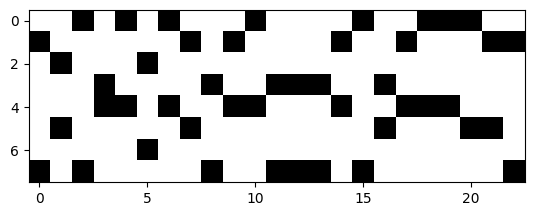

In [5]:
###2.2.4 CRISPR-M

encoded_training_sets_crispr_m = []
encoded_training_sets_crispr_m_on = []
encoded_training_sets_crispr_m_off = []

encoded_testing_sets_crispr_m = []
encoded_testing_sets_crispr_m_on = []
encoded_testing_sets_crispr_m_off = []

for i in range(len(training_sets)):
    temp_set = []
    temp_set_on = []
    temp_set_off = []
    for j in range(len(training_sets[i][0])):
        temp_set.append(encode_by_base_pair_vocabulary(training_sets[i][0][j],training_sets[i][1][j]))
        temp_set_on.append(encode_by_base_vocabulary(training_sets[i][0][j]))
        temp_set_off.append(encode_by_base_vocabulary(training_sets[i][1][j]))
     
    encoded_training_sets_crispr_m.append(temp_set)
    encoded_training_sets_crispr_m_on.append(temp_set_on)
    encoded_training_sets_crispr_m_off.append(temp_set_off)

    temp_set = []
    temp_set_on = []
    temp_set_off = []
    for j in range(len(testing_sets[i][0])):
        temp_set.append(encode_by_base_pair_vocabulary(testing_sets[i][0][j],testing_sets[i][1][j]))
        temp_set_on.append(encode_by_base_vocabulary(testing_sets[i][0][j]))
        temp_set_off.append(encode_by_base_vocabulary(testing_sets[i][1][j]))
     
    encoded_testing_sets_crispr_m.append(temp_set)
    encoded_testing_sets_crispr_m_on.append(temp_set_on)
    encoded_testing_sets_crispr_m_off.append(temp_set_off)


###2.2.5 CrisprDNT

for i in range(len(training_sets)):

    sgrna = training_sets[i][0]
    otdna = training_sets[i][1]
    label = label_sets_train[i]
    data = {'sgrna': sgrna, 'otdna': otdna, 'label': label}
    df = pd.DataFrame(data)
    filename = 'training_set' + str(i) +'.csv'
    df.to_csv(filename, index=False)
    
    %run '/home/remote_guest/Desktop/Programs/Programs/CrisprDNT/create_coding_scheme.py' {filename} {i} train
    
    sgrna_ = testing_sets[i][0]
    otdna_ = testing_sets[i][1]
    label_ = label_sets_test[i]
    data = {'sgrna': sgrna_, 'otdna': otdna_, 'label': label_}
    df = pd.DataFrame(data)
    filename = 'testing_set' + str(i) +'.csv'
    df.to_csv(filename, index=False)
    
    %run '/home/remote_guest/Desktop/Programs/Programs/CrisprDNT/create_coding_scheme.py' {filename} {i} test

    
# for i in range(len(training_sets)):

#     sgrna = training_sets[i][0]
#     otdna = training_sets[i][1]
#     label = label_train[i]
#     data = {'sgrna': sgrna, 'otdna': otdna, 'label': label}
#     df = pd.DataFrame(data)
#     filename = 'training_set' + str(i) +'.csv'
#     df.to_csv(filename, index=False)
    
#     script_path = "/home/remote_guest/Desktop/Programs/Programs/CrisprDNT/create_coding_scheme.py"

#     # Call the script using subprocess
#     subprocess.run(["python", script_path, filename, str(i), "train"])
#     #get_ipython().run_line_magic('run', "'/home/remote_guest/Desktop/Programs/Programs/CrisprDNT/create_coding_scheme.py' {filename} {i} train")
    
#     sgrna_ = testing_sets[i][0]
#     otdna_ = testing_sets[i][1]
#     label_ = label_test[i]
#     data = {'sgrna': sgrna_, 'otdna': otdna_, 'label': label_}
#     df = pd.DataFrame(data)
#     filename = 'testing_set' + str(i) +'.csv'
#     df.to_csv(filename, index=False)

#     script_path = "/home/remote_guest/Desktop/Programs/Programs/CrisprDNT/create_coding_scheme.py"

#     # Call the script using subprocess
#     subprocess.run(["python", script_path, filename, str(i), "test"])

        
###2.2.6 Crispr-SGRU
####2.2.6.1 For training data
encoded_seq_crispr_sgru_list = []
for i in range(len(training_sets)):
    encoded_seqs = []
    for j in range(len(training_sets[i][0])):
        on_target = training_sets[i][0][j]
        off_target = training_sets[i][1][j]
        e = Encoder_sgRNA_off.Encoder(on_seq=on_target, off_seq=off_target)
        encoded_seqs.append(e.on_off_code)
    encoded_seq_crispr_sgru_list.append(encoded_seqs)

encoded_seq_crispr_sgru_train = encoded_seq_crispr_sgru_list

####2.2.6.2 For testing data
encoded_seq_crispr_sgru_list = []
for i in range(len(training_sets)):
    encoded_seqs = []
    for j in range(len(testing_sets[i][0])):
        on_target = testing_sets[i][0][j]
        off_target = testing_sets[i][1][j]
        e = Encoder_sgRNA_off.Encoder(on_seq=on_target, off_seq=off_target)
        encoded_seqs.append(e.on_off_code)
    encoded_seq_crispr_sgru_list.append(encoded_seqs)

encoded_seq_crispr_sgru_test = encoded_seq_crispr_sgru_list

In [4]:
#3 Model training for each program

batch_size_list = [256]
epochs_list = [200]

#batch_size_list = [16, 64, 256, 1024, 2048, 4096]
#epochs_list = [10, 50, 100, 200, 300]

# eary_stopping = EarlyStopping(
#                 monitor='loss', min_delta=0.0001,
#                 patience=10, verbose=1, mode='auto')

# callbacks = [early_stopping]
callbacks = []


In [24]:
###3.1 CRIPSR_Net
PATH = "./Trained_models/Val_only_rev/CRISPR_Net"

for batch_size in batch_size_list:
    computation_time = []
    for epochs in epochs_list:
        for i in range(len(encoded_seq_crispr_net)):
            
            ## Training the model
            TRAIN_X = encoded_seq_crispr_net[i]
            TRAIN_X = TRAIN_X.reshape((len(TRAIN_X), 1, 24, 7))
            TRAIN_y = label_crispr_net[i]

            MODEL = "/CRISPR_Net_5F_model_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) + ".json"
            WEIGHTS = MODEL.replace(".json",".weights.h5")

            start_time = time.time()
            CRISPR_Net_training(PATH, MODEL, TRAIN_X, TRAIN_y, batch_size, epochs)
            end_time = time.time()
            elapsed_time = end_time - start_time
            
            ## Testing the model
            TEST_X = encoded_seq_crispr_net_test[i]
            TEST_X = TEST_X.reshape((len(TEST_X), 1, 24, 7))
            TEST_y = label_crispr_net_test[i]
            
            y_pred = CRISPR_Net_testing(PATH+WEIGHTS, PATH+MODEL, TEST_X, TEST_y)     
            
            print("Set: {}, Batch size: {}, Epochs: {}, Time: {}".format(i, batch_size, epochs, elapsed_time))
            computation_time.append([i, batch_size, epochs, elapsed_time])

            np.save('./New_evaluation/crispr_net/crispr_net_val_only_5F_b' + 
                    str(batch_size) + '_e' + 
                    str(epochs) + '_' + str(i) +
                    '.npy', y_pred)
        
            K.clear_session()
#     comp_timefile = './New_evaluation/crispr_net/comp_5F_b' + str(batch_size) + '_e' + str(epochs) + '.csv'
#     with open(comp_timefile, 'w') as f:
#         for element in computation_time:
#             f.write("{},{},{},{}\n".format(element[0], element[1], element[2], element[3]))

/home/remote_guest/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 24, 10) │          0 │ conv2d_5[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 24, 10) │          0 │ conv2d_6[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 24, 10) │          0 │ conv2d_7[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 24, 10) │          0 │ conv2d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1, 24, 47) │          0 │ main_input[0][0], │
│ (Concatenate)       │                   │            │ activation[0][0], │
│                     │                   │            │ activation_1[0][… │
│                     │                   │            │ activation_2[0][… │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 24, 47)    │          0 │ concatenate_5[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 24, 30)    │      7,560 │ reshape_10[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 720)       │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 80)        │     57,680 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 20)        │      1,620 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 20)        │          0 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,691 (264.42 KB)

 Trainable params: 67,691 (264.42 KB)

 Non-trainable params: 0 (0.00 B)

None
256
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8153
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6841 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5969 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5323 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4805 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4400 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4269 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4287 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4266 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4131 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4088 
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4126 
Epoch 13/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4109 
Epoch 14/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3976 
Epoch 15/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3866 
Epoch 16/30

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2350 
Epoch 164/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2348 
Epoch 165/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2333 
Epoch 166/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2393 
Epoch 167/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2241 
Epoch 168/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2299 
Epoch 169/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2261 
Epoch 170/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2263 
Epoch 171/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2354 
Epoch 172/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2301 
Epoch 173/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2298 
Epoch 174/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2212 
Epoch 175/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2233 
Epoch 176/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2259 
Epoch 177/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2252 
Epoch 178

/home/remote_guest/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 24, 10) │          0 │ conv2d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 24, 10) │          0 │ conv2d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 24, 10) │          0 │ conv2d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 24, 10) │          0 │ conv2d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 47) │          0 │ main_input[0][0], │
│ (Concatenate)       │                   │            │ activation[0][0], │
│                     │                   │            │ activation_1[0][… │
│                     │                   │            │ activation_2[0][… │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 47)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      7,560 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,691 (264.42 KB)

 Trainable params: 67,691 (264.42 KB)

 Non-trainable params: 0 (0.00 B)

None
256
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7183
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6167 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5437 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4891 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4685 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4499 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4471 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4454 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4420 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4350 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4258 
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4208 
Epoch 13/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4264 
Epoch 14/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4196 
Epoch 15/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4158 
Epoch 16/30

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2212 
Epoch 164/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2237 
Epoch 165/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2132 
Epoch 166/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2184 
Epoch 167/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2185 
Epoch 168/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2161 
Epoch 169/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2215 
Epoch 170/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2227 
Epoch 171/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2106 
Epoch 172/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2121 
Epoch 173/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2150 
Epoch 174/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2142 
Epoch 175/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2232 
Epoch 176/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2074 
Epoch 177/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2172 
Epoch 178

/home/remote_guest/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 24, 10) │          0 │ conv2d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 24, 10) │          0 │ conv2d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 24, 10) │          0 │ conv2d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 24, 10) │          0 │ conv2d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 47) │          0 │ main_input[0][0], │
│ (Concatenate)       │                   │            │ activation[0][0], │
│                     │                   │            │ activation_1[0][… │
│                     │                   │            │ activation_2[0][… │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 47)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      7,560 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,691 (264.42 KB)

 Trainable params: 67,691 (264.42 KB)

 Non-trainable params: 0 (0.00 B)

None
256
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6358
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5421 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4787 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4448 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4402 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4216 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4058 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4086 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4062 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3955 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3940 
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3890 
Epoch 13/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3841 
Epoch 14/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3695 
Epoch 15/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3704 
Epoch 16/30

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2437 
Epoch 164/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2412 
Epoch 165/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2423 
Epoch 166/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2366 
Epoch 167/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2400 
Epoch 168/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2332 
Epoch 169/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2311 
Epoch 170/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2352 
Epoch 171/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2278 
Epoch 172/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2318 
Epoch 173/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2314 
Epoch 174/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2318 
Epoch 175/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2301 
Epoch 176/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2360 
Epoch 177/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2320 
Epoch 178

/home/remote_guest/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 24, 10) │          0 │ conv2d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 24, 10) │          0 │ conv2d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 24, 10) │          0 │ conv2d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 24, 10) │          0 │ conv2d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 47) │          0 │ main_input[0][0], │
│ (Concatenate)       │                   │            │ activation[0][0], │
│                     │                   │            │ activation_1[0][… │
│                     │                   │            │ activation_2[0][… │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 47)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      7,560 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,691 (264.42 KB)

 Trainable params: 67,691 (264.42 KB)

 Non-trainable params: 0 (0.00 B)

None
256
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7550
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6981 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6700 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6361 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6022 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5659 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5126 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4845 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4559 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4406 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4429 
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4398 
Epoch 13/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4273 
Epoch 14/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4288 
Epoch 15/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4223 
Epoch 16/30

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2290 
Epoch 164/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2354 
Epoch 165/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2362 
Epoch 166/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2328 
Epoch 167/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2304 
Epoch 168/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2318 
Epoch 169/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2318 
Epoch 170/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2245 
Epoch 171/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2353 
Epoch 172/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2272 
Epoch 173/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2221 
Epoch 174/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2247 
Epoch 175/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2290 
Epoch 176/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2271 
Epoch 177/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2237 
Epoch 178

/home/remote_guest/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 24, 10) │          0 │ conv2d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 24, 10) │          0 │ conv2d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 24, 10) │          0 │ conv2d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 24, 10) │          0 │ conv2d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 47) │          0 │ main_input[0][0], │
│ (Concatenate)       │                   │            │ activation[0][0], │
│                     │                   │            │ activation_1[0][… │
│                     │                   │            │ activation_2[0][… │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 47)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      7,560 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,691 (264.42 KB)

 Trainable params: 67,691 (264.42 KB)

 Non-trainable params: 0 (0.00 B)

None
256
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5975
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5026 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4511 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4265 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4189 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4252 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4076 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4111 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4001 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3929 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3747 
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3678 
Epoch 13/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3718 
Epoch 14/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3656 
Epoch 15/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3497 
Epoch 16/30

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2088 
Epoch 164/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2187 
Epoch 165/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2199 
Epoch 166/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2078 
Epoch 167/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2142 
Epoch 168/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2022 
Epoch 169/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2134 
Epoch 170/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2122 
Epoch 171/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2056 
Epoch 172/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2043 
Epoch 173/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2165 
Epoch 174/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2132 
Epoch 175/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2130 
Epoch 176/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1999 
Epoch 177/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2224 
Epoch 178

In [25]:
###3.2 CRISPR-IP
from Programs.Programs.CRISPR_IP.codes.encoding import my_encode_on_off_dim
from Programs.Programs.CRISPR_IP.codes.CRISPR_IP import transformIO,crispr_ip

num_classes = 2
retrain=False
encoder_shape=(24,7)
seg_len, coding_dim = encoder_shape
PATH = "./Trained_models/Val_only_rev/CRISPR_IP"


for batch_size in batch_size_list:
    computation_time = []
    for epochs in epochs_list:
        for i in range(len(encoded_training_sets_crispr_ip)):
            
            ## Model training 
            train_data_encodings = np.array(encoded_training_sets_crispr_ip[i])
            train_labels = label_sets_train[i]

            start_time = time.time()
            TRAIN_X, TRAIN_Y, inputshape = transformIO(
                train_data_encodings, 
                train_labels, 
                seg_len, 
                coding_dim, 
                num_classes
            )

            model = crispr_ip(TRAIN_X, TRAIN_Y, inputshape, num_classes, batch_size, epochs, callbacks, retrain)
            end_time = time.time()
            elapsed_time = end_time - start_time
            
            ### save the model and weight
            model_jason = model.to_json()
            if os.path.isdir(PATH):
                pass
            else:
                os.mkdir(PATH)
            with open(PATH + "/CRISPR_IP_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) + ".json", "w") as jason_file:
                jason_file.write(model_jason)
                model.save_weights(PATH + "/CRISPR_IP_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) +".weights.h5")

            ## Model testing
            encoding_seq = np.array(encoded_testing_sets_crispr_ip_real[i])
            TEST_X = encoding_seq.reshape(encoding_seq.shape[0], 1, 24, 7)
            TEST_X = TEST_X.astype('float32')
            TEST_Y = label_sets_test[i]

            yscore = model.predict(TEST_X)
            ypred = np.argmax(yscore, axis=1)
            yscore = yscore[:,1]
            
            
            print("Set: {}, Batch size: {}, Epochs: {}, Time: {}".format(i, batch_size, epochs, elapsed_time))
            computation_time.append([i, batch_size, epochs, elapsed_time])

            np.save('./New_evaluation/crispr_ip/crispr_ip_val_only_5F_b' + 
                    str(batch_size) + '_e' + 
                    str(epochs) + '_' + str(i) +
                    '.npy', yscore)
            np.save('./New_evaluation/crispr_ip/crispr_ip_val_only_label_5F_b' + 
                    str(batch_size) + '_e' + 
                    str(epochs) + '_' + str(i) +
                    '.npy', ypred)
            print(yscore)
            
            K.clear_session()
            
#     comp_timefile = './New_evaluation/crispr_ip/comp_b' + str(batch_size) + '_e' + str(epochs) + '.csv'
#     with open(comp_timefile, 'w') as f:
#         for element in computation_time:
#             f.write("{},{},{},{}\n".format(element[0], element[1], element[2], element[3]))



xtrain shape: (2211, 1, 24, 7)
2211 train samples
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5719 - loss: 0.9236
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6866 - loss: 0.6575 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7461 - loss: 0.5571 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7803 - loss: 0.5087 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8168 - loss: 0.4682 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8241 - loss: 0.4432 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8282 - loss: 0.4197 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8472 - loss: 0.4297 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8403 - loss: 0.4003 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8447 - loss: 0.3865 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8470 - loss: 0.3809 
Epoch 12/300
9/9 ━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9038 - loss: 0.2481 
Epoch 138/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9023 - loss: 0.2473 
Epoch 139/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8932 - loss: 0.2567 
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8987 - loss: 0.2420 
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9007 - loss: 0.2442 
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9006 - loss: 0.2592 
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9010 - loss: 0.2406 
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8997 - loss: 0.2458 
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8977 - loss: 0.2491 
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9005 - loss: 0.2402 
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8963 - loss: 0.2472 
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.900

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9197 - loss: 0.1619 
Epoch 274/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9228 - loss: 0.1585 
Epoch 275/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9238 - loss: 0.1556 
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9262 - loss: 0.1665 
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9261 - loss: 0.1529 
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9289 - loss: 0.1494 
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9261 - loss: 0.1545 
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9306 - loss: 0.1553 
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9317 - loss: 0.1484 
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9236 - loss: 0.1541 
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9239 - loss: 0.1536 
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.927

xtrain shape: (2211, 1, 24, 7)
2211 train samples
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5359 - loss: 1.1914
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6246 - loss: 0.7572 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6942 - loss: 0.6474 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7581 - loss: 0.5654 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7833 - loss: 0.5002 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8005 - loss: 0.4978 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8177 - loss: 0.4504 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8186 - loss: 0.4505 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8221 - loss: 0.4226 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8323 - loss: 0.4322 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8310 - loss: 0.4038 
Epoch 12/300
9/9 ━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8906 - loss: 0.2622 
Epoch 138/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8848 - loss: 0.2805 
Epoch 139/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8983 - loss: 0.2716 
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8940 - loss: 0.2723 
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8964 - loss: 0.2611 
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8967 - loss: 0.2642 
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8932 - loss: 0.2511 
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8904 - loss: 0.2626 
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8990 - loss: 0.2671 
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8912 - loss: 0.2530 
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8910 - loss: 0.2553 
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.896

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9194 - loss: 0.1792 
Epoch 274/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9211 - loss: 0.1746 
Epoch 275/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9184 - loss: 0.1738 
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9136 - loss: 0.1801 
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9213 - loss: 0.1679 
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9121 - loss: 0.1887 
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9137 - loss: 0.1987 
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9231 - loss: 0.1827 
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9211 - loss: 0.1696 
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9195 - loss: 0.1691 
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9220 - loss: 0.1700 
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.917

xtrain shape: (2211, 1, 24, 7)
2211 train samples
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6036 - loss: 0.9531
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6701 - loss: 0.7246 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7296 - loss: 0.5966 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7858 - loss: 0.5197 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7971 - loss: 0.4863 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8265 - loss: 0.4679 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8328 - loss: 0.4493 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8344 - loss: 0.4545 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8408 - loss: 0.4481 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8539 - loss: 0.3977 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8404 - loss: 0.4182 
Epoch 12/300
9/9 ━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8846 - loss: 0.2686 
Epoch 138/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8801 - loss: 0.2745 
Epoch 139/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8873 - loss: 0.2794 
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8910 - loss: 0.2681 
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8873 - loss: 0.2753 
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8903 - loss: 0.2704 
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8867 - loss: 0.2637 
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8881 - loss: 0.2706 
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8871 - loss: 0.2659 
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8848 - loss: 0.2730 
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9061 - loss: 0.2646 
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.887

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9085 - loss: 0.2017 
Epoch 274/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9129 - loss: 0.1925 
Epoch 275/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9161 - loss: 0.1789 
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9105 - loss: 0.1873 
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9214 - loss: 0.1818 
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9197 - loss: 0.1852 
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9119 - loss: 0.1885 
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9142 - loss: 0.1793 
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9127 - loss: 0.1844 
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9158 - loss: 0.1967 
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9206 - loss: 0.1810 
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.917

xtrain shape: (2211, 1, 24, 7)
2211 train samples
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5796 - loss: 0.9458
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6899 - loss: 0.6350 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7184 - loss: 0.5738 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7804 - loss: 0.5359 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8065 - loss: 0.4629 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8212 - loss: 0.4395 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8233 - loss: 0.4199 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8343 - loss: 0.4125 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8404 - loss: 0.3939 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8493 - loss: 0.3799 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8472 - loss: 0.3874 
Epoch 12/300
9/9 ━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8973 - loss: 0.2559 
Epoch 138/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8921 - loss: 0.2553 
Epoch 139/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8971 - loss: 0.2551 
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8961 - loss: 0.2608 
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8970 - loss: 0.2581 
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8915 - loss: 0.2691 
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8937 - loss: 0.2581 
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8977 - loss: 0.2617 
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8965 - loss: 0.2543 
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8985 - loss: 0.2552 
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8929 - loss: 0.2733 
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.890

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9155 - loss: 0.1822 
Epoch 274/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9195 - loss: 0.1719 
Epoch 275/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9250 - loss: 0.1714 
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9274 - loss: 0.1654 
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - loss: 0.1948 
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - loss: 0.1754 
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9140 - loss: 0.1757 
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9160 - loss: 0.1639 
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9204 - loss: 0.1670 
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9233 - loss: 0.1711 
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9233 - loss: 0.1698 
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.923

xtrain shape: (2211, 1, 24, 7)
2211 train samples
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4782 - loss: 1.2102
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5810 - loss: 0.8061 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6804 - loss: 0.6278 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7223 - loss: 0.5592 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7686 - loss: 0.5170 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7988 - loss: 0.4818 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8074 - loss: 0.4388 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8257 - loss: 0.4157 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8323 - loss: 0.4159 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8492 - loss: 0.3793 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8457 - loss: 0.4016 
Epoch 12/300
9/9 ━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8931 - loss: 0.2625 
Epoch 138/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8868 - loss: 0.2568 
Epoch 139/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8882 - loss: 0.2612 
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8940 - loss: 0.2505 
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8867 - loss: 0.2494 
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9017 - loss: 0.2633 
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8933 - loss: 0.2576 
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8867 - loss: 0.2564 
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8866 - loss: 0.2663 
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8911 - loss: 0.2536 
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8853 - loss: 0.2640 
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.883

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9256 - loss: 0.1688 
Epoch 274/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9156 - loss: 0.1801 
Epoch 275/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9252 - loss: 0.1678 
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9211 - loss: 0.1665 
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9274 - loss: 0.1648 
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9249 - loss: 0.1766 
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9275 - loss: 0.1666 
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9254 - loss: 0.1540 
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9272 - loss: 0.1548 
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9302 - loss: 0.1541 
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9361 - loss: 0.1493 
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.930

In [26]:
### 3.3 R-CRISPR
from Programs.Programs.R_CRISPR.encoding import encode_by_r_crispr_method
from Programs.Programs.R_CRISPR.R_CRISPR import ConvBn, RepVGGBlock, R_CRISPR_model, R_CRISPR_training

PATH = "./Trained_models/Val_only_rev/R_CRISPR"

for batch_size in batch_size_list:
    computation_time = []
    for epochs in epochs_list:
        for i in range(len(encoded_training_sets_r_crispr)):

            TRAIN_X = np.array(encoded_training_sets_r_crispr[i])
            
            ## Training the model
            start_time = time.time()
            model = R_CRISPR_training(TRAIN_X, label_sets_train[i], batch_size, epochs, callbacks)
            end_time = time.time()
            elapsed_time = end_time - start_time
            
            ### save the model and weight
            model_jason = model.to_json()
            if os.path.isdir(PATH):
                pass
            else:
                os.mkdir(PATH)
            with open(PATH + "/R_CRISPR_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) + ".json", "w") as jason_file:
                jason_file.write(model_jason)
                model.save_weights(PATH + "/R_CRISPR_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) +".weights.h5")

            ## Testing the model
            TEST_X = np.array(encoded_testing_sets_r_crispr[i], dtype=np.float32)
            TEST_Y = label_sets_test[i]
            yscore = model.predict(TEST_X)

            np.save('./New_evaluation/r_crispr/r_crispr_val_only_5F_b' + 
                    str(batch_size) + '_e' + 
                    str(epochs) + '_' + str(i) +
                    '.npy', yscore)
            
            print("Set: {}, Batch size: {}, Epochs: {}, Time: {}".format(i, batch_size, epochs, elapsed_time))
            computation_time.append([i, batch_size, epochs, elapsed_time])
            
            K.clear_session()
            
#     comp_timefile = './New_evaluation/r_crispr/comp_b' + str(batch_size) + '_e' + str(epochs) + '.csv'
#     with open(comp_timefile, 'w') as f:
#         for element in computation_time:
#             f.write("{},{},{},{}\n".format(element[0], element[1], element[2], element[3]))


/home/remote_guest/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 24, 7)  │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 15) │        120 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 15) │        675 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 15) │        225 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 24, 15) │         60 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 15) │         60 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 24, 15) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1, 24, 15) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 15)    │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      3,720 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,181 (250.71 KB)

 Trainable params: 64,121 (250.47 KB)

 Non-trainable params: 60 (240.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4937 - auprc: 0.1360 - auroc: 0.4422 - loss: 0.6988
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8130 - auprc: 0.1573 - auroc: 0.5133 - loss: 0.5959 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8446 - auprc: 0.1497 - auroc: 0.5047 - loss: 0.5401 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8484 - auprc: 0.1623 - auroc: 0.5214 - loss: 0.4946 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8492 - auprc: 0.1511 - auroc: 0.4962 - loss: 0.4696 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8505 - auprc: 0.1467 - auroc: 0.4889 - loss: 0.4605 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8488 - auprc: 0.1826 - auroc: 0.5787 - loss: 0.4335 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8493 - auprc: 0.1896 - auroc: 0.6013 - loss: 0.4252 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8490 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9106 - auprc: 0.7460 - auroc: 0.9268 - loss: 0.2262 
Epoch 110/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9075 - auprc: 0.7561 - auroc: 0.9263 - loss: 0.2258 
Epoch 111/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9081 - auprc: 0.7384 - auroc: 0.9245 - loss: 0.2288 
Epoch 112/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9077 - auprc: 0.7498 - auroc: 0.9267 - loss: 0.2273 
Epoch 113/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9133 - auprc: 0.7642 - auroc: 0.9255 - loss: 0.2240 
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9049 - auprc: 0.7560 - auroc: 0.9280 - loss: 0.2238 
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9093 - auprc: 0.7669 - auroc: 0.9292 - loss: 0.2214 
Epoch 116/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9199 - auprc: 0.7746 - auroc: 0.9337 - loss: 0.2169 
Epoch 117/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9104 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9365 - auprc: 0.8734 - auroc: 0.9701 - loss: 0.1583 
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9392 - auprc: 0.8741 - auroc: 0.9670 - loss: 0.1608 
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9291 - auprc: 0.8547 - auroc: 0.9649 - loss: 0.1664 
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9303 - auprc: 0.8526 - auroc: 0.9636 - loss: 0.1696 
Epoch 219/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9351 - auprc: 0.8672 - auroc: 0.9674 - loss: 0.1610 
Epoch 220/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9357 - auprc: 0.8715 - auroc: 0.9686 - loss: 0.1595 
Epoch 221/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9357 - auprc: 0.8615 - auroc: 0.9644 - loss: 0.1664 
Epoch 222/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9345 - auprc: 0.8708 - auroc: 0.9684 - loss: 0.1596 
Epoch 223/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9338 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 24, 7)  │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 15) │        120 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 15) │        675 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 15) │        225 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 24, 15) │         60 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 15) │         60 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 24, 15) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1, 24, 15) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 15)    │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      3,720 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,181 (250.71 KB)

 Trainable params: 64,121 (250.47 KB)

 Non-trainable params: 60 (240.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6319 - auprc: 0.2118 - auroc: 0.5581 - loss: 0.6630
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8280 - auprc: 0.2387 - auroc: 0.5728 - loss: 0.5591 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8401 - auprc: 0.2231 - auroc: 0.5787 - loss: 0.4927 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8426 - auprc: 0.2165 - auroc: 0.5810 - loss: 0.4549 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8401 - auprc: 0.2515 - auroc: 0.6130 - loss: 0.4326 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8416 - auprc: 0.2580 - auroc: 0.6330 - loss: 0.4244 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8423 - auprc: 0.3027 - auroc: 0.6579 - loss: 0.4148 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8446 - auprc: 0.3514 - auroc: 0.6840 - loss: 0.4047 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8493 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9205 - auprc: 0.8269 - auroc: 0.9422 - loss: 0.2097 
Epoch 110/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9118 - auprc: 0.8046 - auroc: 0.9376 - loss: 0.2171 
Epoch 111/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9111 - auprc: 0.8131 - auroc: 0.9449 - loss: 0.2092 
Epoch 112/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9202 - auprc: 0.8242 - auroc: 0.9445 - loss: 0.2061 
Epoch 113/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9124 - auprc: 0.8073 - auroc: 0.9390 - loss: 0.2130 
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9138 - auprc: 0.8085 - auroc: 0.9413 - loss: 0.2123 
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9179 - auprc: 0.8279 - auroc: 0.9472 - loss: 0.2028 
Epoch 116/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9170 - auprc: 0.8089 - auroc: 0.9369 - loss: 0.2131 
Epoch 117/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9191 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9393 - auprc: 0.9129 - auroc: 0.9799 - loss: 0.1388 
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9417 - auprc: 0.9179 - auroc: 0.9825 - loss: 0.1335 
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9451 - auprc: 0.9214 - auroc: 0.9820 - loss: 0.1333 
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9402 - auprc: 0.9093 - auroc: 0.9793 - loss: 0.1396 
Epoch 219/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9422 - auprc: 0.9162 - auroc: 0.9813 - loss: 0.1346 
Epoch 220/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9404 - auprc: 0.9070 - auroc: 0.9775 - loss: 0.1417 
Epoch 221/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9441 - auprc: 0.9246 - auroc: 0.9826 - loss: 0.1320 
Epoch 222/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9406 - auprc: 0.9121 - auroc: 0.9804 - loss: 0.1375 
Epoch 223/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9433 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 24, 7)  │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 15) │        120 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 15) │        675 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 15) │        225 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 24, 15) │         60 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 15) │         60 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 24, 15) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1, 24, 15) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 15)    │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      3,720 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,181 (250.71 KB)

 Trainable params: 64,121 (250.47 KB)

 Non-trainable params: 60 (240.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6065 - auprc: 0.1372 - auroc: 0.4770 - loss: 0.6592
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8108 - auprc: 0.1383 - auroc: 0.4843 - loss: 0.5231 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8338 - auprc: 0.1539 - auroc: 0.5205 - loss: 0.4644 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8482 - auprc: 0.1621 - auroc: 0.5334 - loss: 0.4499 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8500 - auprc: 0.1615 - auroc: 0.5209 - loss: 0.4546 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8496 - auprc: 0.1601 - auroc: 0.5280 - loss: 0.4481 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8490 - auprc: 0.1722 - auroc: 0.5800 - loss: 0.4320 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8474 - auprc: 0.1951 - auroc: 0.6155 - loss: 0.4198 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8501 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9029 - auprc: 0.7218 - auroc: 0.9145 - loss: 0.2410 
Epoch 110/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9051 - auprc: 0.7148 - auroc: 0.9120 - loss: 0.2429 
Epoch 111/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9029 - auprc: 0.6967 - auroc: 0.9138 - loss: 0.2436 
Epoch 112/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9024 - auprc: 0.7123 - auroc: 0.9127 - loss: 0.2422 
Epoch 113/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8992 - auprc: 0.7111 - auroc: 0.9194 - loss: 0.2372 
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8992 - auprc: 0.7147 - auroc: 0.9154 - loss: 0.2407 
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9006 - auprc: 0.7179 - auroc: 0.9202 - loss: 0.2359 
Epoch 116/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9030 - auprc: 0.7239 - auroc: 0.9225 - loss: 0.2330 
Epoch 117/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8977 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9189 - auprc: 0.8210 - auroc: 0.9557 - loss: 0.1842 
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9223 - auprc: 0.8251 - auroc: 0.9598 - loss: 0.1803 
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - auprc: 0.8155 - auroc: 0.9572 - loss: 0.1847 
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9215 - auprc: 0.8185 - auroc: 0.9547 - loss: 0.1859 
Epoch 219/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9215 - auprc: 0.8238 - auroc: 0.9590 - loss: 0.1822 
Epoch 220/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9244 - auprc: 0.8224 - auroc: 0.9578 - loss: 0.1820 
Epoch 221/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9221 - auprc: 0.8217 - auroc: 0.9571 - loss: 0.1841 
Epoch 222/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9297 - auprc: 0.8398 - auroc: 0.9606 - loss: 0.1781 
Epoch 223/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9258 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 24, 7)  │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 15) │        120 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 15) │        675 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 15) │        225 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 24, 15) │         60 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 15) │         60 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 24, 15) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1, 24, 15) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 15)    │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      3,720 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,181 (250.71 KB)

 Trainable params: 64,121 (250.47 KB)

 Non-trainable params: 60 (240.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7130 - auprc: 0.1615 - auroc: 0.5521 - loss: 0.6088
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8398 - auprc: 0.2030 - auroc: 0.6103 - loss: 0.4842 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8462 - auprc: 0.1897 - auroc: 0.5863 - loss: 0.4350 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8468 - auprc: 0.2278 - auroc: 0.6410 - loss: 0.4143 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8468 - auprc: 0.2266 - auroc: 0.6437 - loss: 0.4130 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8468 - auprc: 0.2479 - auroc: 0.6589 - loss: 0.4075 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8480 - auprc: 0.3140 - auroc: 0.7199 - loss: 0.3920 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8463 - auprc: 0.3662 - auroc: 0.7569 - loss: 0.3824 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8468 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9205 - auprc: 0.8035 - auroc: 0.9376 - loss: 0.2097 
Epoch 110/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9206 - auprc: 0.7942 - auroc: 0.9288 - loss: 0.2189 
Epoch 111/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9198 - auprc: 0.8104 - auroc: 0.9332 - loss: 0.2141 
Epoch 112/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9166 - auprc: 0.8028 - auroc: 0.9317 - loss: 0.2129 
Epoch 113/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9221 - auprc: 0.8103 - auroc: 0.9388 - loss: 0.2062 
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9231 - auprc: 0.8122 - auroc: 0.9412 - loss: 0.2053 
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9158 - auprc: 0.8006 - auroc: 0.9346 - loss: 0.2121 
Epoch 116/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - auprc: 0.8129 - auroc: 0.9399 - loss: 0.2070 
Epoch 117/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9209 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9395 - auprc: 0.8903 - auroc: 0.9709 - loss: 0.1527 
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9402 - auprc: 0.8864 - auroc: 0.9705 - loss: 0.1546 
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9397 - auprc: 0.8957 - auroc: 0.9726 - loss: 0.1487 
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9419 - auprc: 0.9072 - auroc: 0.9778 - loss: 0.1407 
Epoch 219/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9387 - auprc: 0.8908 - auroc: 0.9741 - loss: 0.1485 
Epoch 220/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9421 - auprc: 0.8937 - auroc: 0.9732 - loss: 0.1489 
Epoch 221/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9433 - auprc: 0.9015 - auroc: 0.9767 - loss: 0.1433 
Epoch 222/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9384 - auprc: 0.8946 - auroc: 0.9750 - loss: 0.1462 
Epoch 223/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9387 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 24, 7)  │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 15) │        120 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 15) │        675 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 15) │        225 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 24, 15) │         60 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 15) │         60 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 24, 15) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1, 24, 15) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 15)    │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 30)    │      3,720 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │     57,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,620 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,181 (250.71 KB)

 Trainable params: 64,121 (250.47 KB)

 Non-trainable params: 60 (240.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5005 - auprc: 0.1442 - auroc: 0.4677 - loss: 0.6958
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7893 - auprc: 0.1374 - auroc: 0.4837 - loss: 0.5521 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8426 - auprc: 0.1741 - auroc: 0.5194 - loss: 0.4738 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8468 - auprc: 0.1798 - auroc: 0.5875 - loss: 0.4331 
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8496 - auprc: 0.1591 - auroc: 0.5432 - loss: 0.4384 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8526 - auprc: 0.1873 - auroc: 0.6162 - loss: 0.4167 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8538 - auprc: 0.2246 - auroc: 0.6345 - loss: 0.4078 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8531 - auprc: 0.2185 - auroc: 0.6495 - loss: 0.4042 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8502 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9085 - auprc: 0.7327 - auroc: 0.9115 - loss: 0.2362 
Epoch 110/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9133 - auprc: 0.7428 - auroc: 0.9154 - loss: 0.2328 
Epoch 111/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9123 - auprc: 0.7661 - auroc: 0.9220 - loss: 0.2240 
Epoch 112/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9127 - auprc: 0.7668 - auroc: 0.9241 - loss: 0.2228 
Epoch 113/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9100 - auprc: 0.7609 - auroc: 0.9215 - loss: 0.2235 
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9065 - auprc: 0.7352 - auroc: 0.9124 - loss: 0.2347 
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9163 - auprc: 0.7575 - auroc: 0.9275 - loss: 0.2209 
Epoch 116/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9229 - auprc: 0.7876 - auroc: 0.9374 - loss: 0.2091 
Epoch 117/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9193 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9386 - auprc: 0.8753 - auroc: 0.9679 - loss: 0.1546 
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9468 - auprc: 0.8861 - auroc: 0.9700 - loss: 0.1490 
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9437 - auprc: 0.8899 - auroc: 0.9726 - loss: 0.1465 
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9405 - auprc: 0.8918 - auroc: 0.9749 - loss: 0.1450 
Epoch 219/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9442 - auprc: 0.8884 - auroc: 0.9733 - loss: 0.1464 
Epoch 220/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9437 - auprc: 0.8894 - auroc: 0.9728 - loss: 0.1470 
Epoch 221/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9433 - auprc: 0.8944 - auroc: 0.9732 - loss: 0.1456 
Epoch 222/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9461 - auprc: 0.8912 - auroc: 0.9731 - loss: 0.1456 
Epoch 223/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9430 

In [27]:
### 3.4 CRISPR-M
from Programs.Programs.CRISPR_M.positional_encoding import PositionalEncoding
from Programs.Programs.CRISPR_M.transformer_utils import add_encoder_layer, add_decoder_layer
from Programs.Programs.CRISPR_M.test_model import m81212_n13
from Programs.Programs.CRISPR_M.encoding import encode_by_base_pair_vocabulary, encode_by_base_vocabulary
from Programs.Programs.CRISPR_M.mismatch_test import Trainer

PATH = "./Trained_models/Val_only_rev/CRISPR_M"

for batch_size in batch_size_list:
    computation_time = []
    for epochs in epochs_list:
        for i in range(len(encoded_training_sets_crispr_m)):
            
            ## Training the model
            trainer = Trainer()

            TRAIN_X = np.array(encoded_training_sets_crispr_m[i])
            ont = np.array(encoded_training_sets_crispr_m_on[i])
            offt = np.array(encoded_training_sets_crispr_m_off[i])
            
            trainer.BATCH_SIZE = int(batch_size)
            trainer.N_EPOCHS = int(epochs)
            trainer.train_features = np.array(TRAIN_X, dtype=np.float32)
            trainer.train_feature_ont = np.array(ont, dtype=np.float32)
            trainer.train_feature_offt = np.array(offt, dtype=np.float32)
            trainer.train_labels = np.array(label_sets_train[i], dtype=np.float32)
            
            print("train_features dtype:", trainer.train_features.dtype)
            print("train_feature_ont dtype:", trainer.train_feature_ont.dtype)
            print("train_feature_offt dtype:", trainer.train_feature_offt.dtype)
            print("train_labels dtype:", trainer.train_labels.dtype)


            start_time = time.time()
            model = trainer.train_model()
            end_time = time.time()
            elapsed_time = end_time - start_time

            model_jason = model.to_json()
            if os.path.isdir(PATH):
                pass
            else:
                os.mkdir(PATH)
            with open(PATH + "/CRISPR_M_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) + ".json", "w") as jason_file:
                jason_file.write(model_jason)
                model.save_weights(PATH + "/CRISPR_M_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) +".weights.h5")

                
            ## Testing the model
            TEST_X = np.array(encoded_testing_sets_crispr_m[i], dtype=np.float32)
            TEST_X_on = np.array(encoded_testing_sets_crispr_m_on[i], dtype=np.float32)
            TEST_X_off = np.array(encoded_testing_sets_crispr_m_off[i], dtype=np.float32)
            TEST_Y = label_sets_test[i]
    
            yscore = model.predict([TEST_X, TEST_X_on, TEST_X_off])
            print(yscore)


            np.save('./New_evaluation/crispr_m/crispr_m_val_only_5F_b' + 
                    str(batch_size) + '_e' + 
                    str(epochs) + '_' + str(i) +
                    '.npy', yscore)
            
            print("Set: {}, Batch size: {}, Epochs: {}, Time: {}".format(i, batch_size, epochs, elapsed_time))
            computation_time.append([i, batch_size, epochs, elapsed_time])
            
            K.clear_session()
            
#     comp_timefile = './New_evaluation/crispr_m/comp_b' + str(batch_size) + '_e' + str(epochs) + '.csv'
#     with open(comp_timefile, 'w') as f:
#         for element in computation_time:
#             f.write("{},{},{},{}\n".format(element[0], element[1], element[2], element[3]))



train_features dtype: float32
train_feature_ont dtype: float32
train_feature_offt dtype: float32
train_labels dtype: float32
[INFO] ===== Start train =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 7)     │        210 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0],    │
│                     │                   │            │ input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 24, 7)     │          0 │ embedding[0][0],  │
│ (PositionalEncodin… │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 4, 32) │        160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 4, 32) │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 4, 32) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 1, 64) │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 1, 64) │        512 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,706,040 (6.51 MB)

 Trainable params: 1,704,824 (6.50 MB)

 Non-trainable params: 1,216 (4.75 KB)

self.train_features: [[24. 15.  3. ... 12. 13.  2.]
 [24.  5.  1. ...  2.  2.  2.]
 [24.  1.  3. ...  0.  2.  2.]
 ...
 [24.  2.  2. ... 10.  2.  2.]
 [24.  2.  2. ... 10.  2.  2.]
 [24. 13.  2. ...  7.  2.  2.]]
self.train_feature_ont: [[29. 28. 28. ... 28. 27. 27.]
 [29. 25. 26. ... 27. 27. 27.]
 [29. 26. 28. ... 25. 27. 27.]
 ...
 [29. 27. 27. ... 26. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]]
self.train_feature_offt: [[29. 27. 28. ... 25. 26. 27.]
 [29. 27. 26. ... 27. 27. 27.]
 [29. 26. 28. ... 25. 27. 27.]
 ...
 [29. 27. 27. ... 25. 27. 27.]
 [29. 27. 27. ... 25. 27. 27.]
 [29. 26. 27. ... 27. 27. 27.]]
self.train_labels: [0. 0. 0. ... 0. 0. 0.]
self.train_features shape: (2211, 24)
self.train_feature_ont shape: (2211, 24)
self.train_feature_offt shape: (2211, 24)
self.train_labels shape: (2211,)
Epoch 1/300


E0000 00:00:1743247558.050999 3567720 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.4858 - auprc: 0.1468 - auroc: 0.4904 - loss: 1.5266
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.4926 - auprc: 0.1455 - auroc: 0.4887 - loss: 1.4415
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.5292 - auprc: 0.1650 - auroc: 0.5244 - loss: 1.2966
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5506 - auprc: 0.1520 - auroc: 0.5113 - loss: 1.2355
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5474 - auprc: 0.1802 - auroc: 0.5549 - loss: 1.1052
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.5726 - auprc: 0.2010 - auroc: 0.5761 - loss: 1.0450
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5726 - auprc: 0.1720 - auroc: 0.5393 - loss: 1.0430
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5771 - auprc: 0.1749 - auroc: 0.5584 - loss: 0.9924
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.5998 - auprc: 0.1889 - auroc: 0.5707 - loss: 0.9251
Epoch 10/300


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.8996 - auprc: 0.6936 - auroc: 0.8789 - loss: 0.2672
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8972 - auprc: 0.6758 - auroc: 0.8833 - loss: 0.2682
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8993 - auprc: 0.6968 - auroc: 0.8937 - loss: 0.2638
Epoch 116/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8979 - auprc: 0.6903 - auroc: 0.8826 - loss: 0.2694
Epoch 117/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8945 - auprc: 0.6767 - auroc: 0.8811 - loss: 0.2707
Epoch 118/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8981 - auprc: 0.7038 - auroc: 0.8875 - loss: 0.2603
Epoch 119/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8948 - auprc: 0.6751 - auroc: 0.8789 - loss: 0.2719
Epoch 120/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8973 - auprc: 0.6908 - auroc: 0.8964 - loss: 0.2602
Epoch 121/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9054 - auprc: 0.6874 - auroc: 0.8779 - loss: 0.26

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9088 - auprc: 0.7510 - auroc: 0.9139 - loss: 0.2330
Epoch 224/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9060 - auprc: 0.7590 - auroc: 0.9183 - loss: 0.2343
Epoch 225/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9098 - auprc: 0.7460 - auroc: 0.9124 - loss: 0.2313
Epoch 226/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9070 - auprc: 0.7436 - auroc: 0.9160 - loss: 0.2347
Epoch 227/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9074 - auprc: 0.7561 - auroc: 0.9205 - loss: 0.2246
Epoch 228/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9150 - auprc: 0.7636 - auroc: 0.9205 - loss: 0.2254
Epoch 229/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9111 - auprc: 0.7505 - auroc: 0.9129 - loss: 0.2293
Epoch 230/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.9169 - auprc: 0.7579 - auroc: 0.9193 - loss: 0.2274
Epoch 231/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9139 - auprc: 0.7611 - auroc: 0.9201 - loss: 0.22

train_features dtype: float32
train_feature_ont dtype: float32
train_feature_offt dtype: float32
train_labels dtype: float32
[INFO] ===== Start train =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 7)     │        210 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0],    │
│                     │                   │            │ input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 24, 7)     │          0 │ embedding[0][0],  │
│ (PositionalEncodin… │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 4, 32) │        160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 4, 32) │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 4, 32) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 1, 64) │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 1, 64) │        512 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,706,040 (6.51 MB)

 Trainable params: 1,704,824 (6.50 MB)

 Non-trainable params: 1,216 (4.75 KB)

self.train_features: [[24.  3. 10. ...  0.  2.  2.]
 [24. 13.  2. ...  1.  2.  2.]
 [24.  6.  0. ... 11.  2.  2.]
 ...
 [24. 13.  2. ... 15.  2. 11.]
 [24.  2.  2. ... 15.  2. 11.]
 [24.  5. 10. ...  2.  2. 11.]]
self.train_feature_ont: [[29. 28. 26. ... 25. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]
 [29. 25. 25. ... 27. 27. 27.]
 ...
 [29. 27. 27. ... 28. 27. 27.]
 [29. 27. 27. ... 28. 27. 27.]
 [29. 25. 26. ... 27. 27. 27.]]
self.train_feature_offt: [[29. 28. 25. ... 25. 27. 27.]
 [29. 26. 27. ... 26. 27. 27.]
 [29. 28. 25. ... 25. 27. 27.]
 ...
 [29. 26. 27. ... 27. 27. 25.]
 [29. 27. 27. ... 27. 27. 25.]
 [29. 27. 25. ... 27. 27. 25.]]
self.train_labels: [0. 0. 0. ... 0. 0. 0.]
self.train_features shape: (2211, 24)
self.train_feature_ont shape: (2211, 24)
self.train_feature_offt shape: (2211, 24)
self.train_labels shape: (2211,)
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - acc: 0.5163 - auprc: 0.1557 - auroc: 0.5028 - loss: 1.3258
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8888 - auprc: 0.7044 - auroc: 0.8762 - loss: 0.2788
Epoch 108/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8907 - auprc: 0.6928 - auroc: 0.8731 - loss: 0.2806
Epoch 109/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8922 - auprc: 0.6934 - auroc: 0.8733 - loss: 0.2862
Epoch 110/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8941 - auprc: 0.6895 - auroc: 0.8737 - loss: 0.2814
Epoch 111/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8974 - auprc: 0.7201 - auroc: 0.8858 - loss: 0.2660
Epoch 112/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8982 - auprc: 0.7022 - auroc: 0.8733 - loss: 0.2763
Epoch 113/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8920 - auprc: 0.7041 - auroc: 0.8765 - loss: 0.2760
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8905 - auprc: 0.7079 - auroc: 0.8850 - loss: 0.2703
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.8966 - auprc: 0.7025 - auroc: 0.8756 - loss: 0.27

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9131 - auprc: 0.7906 - auroc: 0.9171 - loss: 0.2256
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9218 - auprc: 0.8084 - auroc: 0.9216 - loss: 0.2134
Epoch 219/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9233 - auprc: 0.8018 - auroc: 0.9137 - loss: 0.2217
Epoch 220/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9195 - auprc: 0.7971 - auroc: 0.9146 - loss: 0.2250
Epoch 221/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9187 - auprc: 0.7961 - auroc: 0.9137 - loss: 0.2240
Epoch 222/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9217 - auprc: 0.8101 - auroc: 0.9248 - loss: 0.2131
Epoch 223/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9163 - auprc: 0.7942 - auroc: 0.9156 - loss: 0.2270
Epoch 224/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.9240 - auprc: 0.8017 - auroc: 0.9112 - loss: 0.2249
Epoch 225/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.9200 - auprc: 0.7962 - auroc: 0.9147 - loss: 0.22

train_features dtype: float32
train_feature_ont dtype: float32
train_feature_offt dtype: float32
train_labels dtype: float32
[INFO] ===== Start train =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 7)     │        210 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0],    │
│                     │                   │            │ input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 24, 7)     │          0 │ embedding[0][0],  │
│ (PositionalEncodin… │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 4, 32) │        160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 4, 32) │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 4, 32) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 1, 64) │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 1, 64) │        512 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,706,040 (6.51 MB)

 Trainable params: 1,704,824 (6.50 MB)

 Non-trainable params: 1,216 (4.75 KB)

self.train_features: [[24.  2. 11. ...  7.  2.  2.]
 [24.  2.  2. ...  7.  2.  2.]
 [24.  2.  2. ... 10.  2.  2.]
 ...
 [24.  3.  1. ... 13.  2.  2.]
 [24. 13. 13. ...  1.  2.  2.]
 [24.  9.  9. ...  1.  2.  9.]]
self.train_feature_ont: [[29. 27. 27. ... 26. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]
 ...
 [29. 28. 26. ... 27. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]]
self.train_feature_offt: [[29. 27. 25. ... 27. 27. 27.]
 [29. 27. 27. ... 27. 27. 27.]
 [29. 27. 27. ... 25. 27. 27.]
 ...
 [29. 28. 26. ... 26. 27. 27.]
 [29. 26. 26. ... 26. 27. 27.]
 [29. 28. 28. ... 26. 27. 28.]]
self.train_labels: [1. 0. 0. ... 0. 0. 0.]
self.train_features shape: (2211, 24)
self.train_feature_ont shape: (2211, 24)
self.train_feature_offt shape: (2211, 24)
self.train_labels shape: (2211,)
Epoch 1/300


E0000 00:00:1743247673.738877 3567720 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - acc: 0.5166 - auprc: 0.1610 - auroc: 0.5128 - loss: 1.3292
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.5413 - auprc: 0.1578 - auroc: 0.5364 - loss: 1.2583
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5155 - auprc: 0.1415 - auroc: 0.4723 - loss: 1.2940
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5162 - auprc: 0.1367 - auroc: 0.4649 - loss: 1.1792
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.5674 - auprc: 0.1729 - auroc: 0.5481 - loss: 1.0315
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.5738 - auprc: 0.1738 - auroc: 0.5608 - loss: 1.0093
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5828 - auprc: 0.2012 - auroc: 0.5830 - loss: 0.9421
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.5996 - auprc: 0.1790 - auroc: 0.5587 - loss: 0.8879
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.6159 - auprc: 0.2319 - auroc: 0.6051 - loss: 0.8668
Epoch 10/300


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8856 - auprc: 0.6348 - auroc: 0.8726 - loss: 0.2830
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8868 - auprc: 0.6228 - auroc: 0.8626 - loss: 0.3047
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8885 - auprc: 0.6450 - auroc: 0.8648 - loss: 0.2879
Epoch 116/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8916 - auprc: 0.6710 - auroc: 0.8756 - loss: 0.2716
Epoch 117/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8853 - auprc: 0.6353 - auroc: 0.8626 - loss: 0.2846
Epoch 118/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8894 - auprc: 0.6608 - auroc: 0.8752 - loss: 0.2732
Epoch 119/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8831 - auprc: 0.6408 - auroc: 0.8643 - loss: 0.2850
Epoch 120/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8940 - auprc: 0.6624 - auroc: 0.8701 - loss: 0.2760
Epoch 121/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8923 - auprc: 0.6463 - auroc: 0.8625 - loss: 0.28

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9061 - auprc: 0.7435 - auroc: 0.9178 - loss: 0.2321
Epoch 224/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9091 - auprc: 0.7390 - auroc: 0.9129 - loss: 0.2338
Epoch 225/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8989 - auprc: 0.7300 - auroc: 0.9118 - loss: 0.2368
Epoch 226/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9114 - auprc: 0.7566 - auroc: 0.9227 - loss: 0.2228
Epoch 227/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.9050 - auprc: 0.7444 - auroc: 0.9143 - loss: 0.2321
Epoch 228/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.9110 - auprc: 0.7570 - auroc: 0.9187 - loss: 0.2268
Epoch 229/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9100 - auprc: 0.7580 - auroc: 0.9234 - loss: 0.2258
Epoch 230/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9145 - auprc: 0.7620 - auroc: 0.9240 - loss: 0.2216
Epoch 231/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9049 - auprc: 0.7440 - auroc: 0.9166 - loss: 0.23

train_features dtype: float32
train_feature_ont dtype: float32
train_feature_offt dtype: float32
train_labels dtype: float32
[INFO] ===== Start train =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 7)     │        210 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0],    │
│                     │                   │            │ input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 24, 7)     │          0 │ embedding[0][0],  │
│ (PositionalEncodin… │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 4, 32) │        160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 4, 32) │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 4, 32) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 1, 64) │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 1, 64) │        512 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,706,040 (6.51 MB)

 Trainable params: 1,704,824 (6.50 MB)

 Non-trainable params: 1,216 (4.75 KB)

self.train_features: [[24.  5.  0. ... 11.  2.  2.]
 [24. 10.  9. ...  1.  2.  2.]
 [24. 11.  3. ...  0.  2.  2.]
 ...
 [24.  4. 10. ...  2.  2. 13.]
 [24.  2.  2. ...  1.  2. 11.]
 [24.  2.  0. ... 13.  2.  2.]]
self.train_feature_ont: [[29. 25. 25. ... 27. 27. 27.]
 [29. 26. 27. ... 26. 27. 27.]
 [29. 27. 28. ... 25. 27. 27.]
 ...
 [29. 25. 26. ... 27. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]
 [29. 27. 25. ... 27. 27. 27.]]
self.train_feature_offt: [[29. 27. 25. ... 25. 27. 27.]
 [29. 25. 28. ... 26. 27. 27.]
 [29. 25. 28. ... 25. 27. 27.]
 ...
 [29. 26. 25. ... 27. 27. 26.]
 [29. 27. 27. ... 26. 27. 25.]
 [29. 27. 25. ... 26. 27. 27.]]
self.train_labels: [0. 1. 0. ... 0. 0. 0.]
self.train_features shape: (2211, 24)
self.train_feature_ont shape: (2211, 24)
self.train_feature_offt shape: (2211, 24)
self.train_labels shape: (2211,)
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.4771 - auprc: 0.1497 - auroc: 0.4862 - loss: 1.4985
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8932 - auprc: 0.6765 - auroc: 0.8822 - loss: 0.2746
Epoch 108/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8939 - auprc: 0.6842 - auroc: 0.8752 - loss: 0.2727
Epoch 109/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8919 - auprc: 0.6782 - auroc: 0.8742 - loss: 0.2777
Epoch 110/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8908 - auprc: 0.6617 - auroc: 0.8570 - loss: 0.2855
Epoch 111/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8855 - auprc: 0.6600 - auroc: 0.8693 - loss: 0.2822
Epoch 112/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8876 - auprc: 0.6614 - auroc: 0.8682 - loss: 0.2828
Epoch 113/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8915 - auprc: 0.6671 - auroc: 0.8668 - loss: 0.2831
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8925 - auprc: 0.6726 - auroc: 0.8536 - loss: 0.2848
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8984 - auprc: 0.6747 - auroc: 0.8589 - loss: 0.28

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9106 - auprc: 0.7538 - auroc: 0.9034 - loss: 0.2389
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9097 - auprc: 0.7675 - auroc: 0.9148 - loss: 0.2293
Epoch 219/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.9130 - auprc: 0.7524 - auroc: 0.9057 - loss: 0.2381
Epoch 220/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9114 - auprc: 0.7575 - auroc: 0.9033 - loss: 0.2358
Epoch 221/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9152 - auprc: 0.7648 - auroc: 0.9028 - loss: 0.2339
Epoch 222/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9100 - auprc: 0.7544 - auroc: 0.9041 - loss: 0.2380
Epoch 223/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9150 - auprc: 0.7761 - auroc: 0.9164 - loss: 0.2221
Epoch 224/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9156 - auprc: 0.7729 - auroc: 0.9071 - loss: 0.2279
Epoch 225/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9121 - auprc: 0.7608 - auroc: 0.9072 - loss: 0.23

train_features dtype: float32
train_feature_ont dtype: float32
train_feature_offt dtype: float32
train_labels dtype: float32
[INFO] ===== Start train =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 7)     │        210 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0],    │
│                     │                   │            │ input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 24, 7)     │          0 │ embedding[0][0],  │
│ (PositionalEncodin… │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3             │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 4, 32) │        160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 4, 32) │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 4, 32) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 7, 1)  │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │      1,495 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 1, 64) │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 1, 64) │        512 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 24, 7, 1)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,706,040 (6.51 MB)

 Trainable params: 1,704,824 (6.50 MB)

 Non-trainable params: 1,216 (4.75 KB)

self.train_features: [[24. 13. 13. ...  1.  2.  2.]
 [24. 13.  2. ...  7.  2.  2.]
 [24.  2.  2. ...  0.  2.  2.]
 ...
 [24. 11.  2. ... 15.  2.  9.]
 [24. 11. 13. ... 10.  2.  2.]
 [24. 12. 10. ...  8.  2.  2.]]
self.train_feature_ont: [[29. 27. 27. ... 26. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]
 [29. 27. 27. ... 25. 27. 27.]
 ...
 [29. 27. 27. ... 28. 27. 27.]
 [29. 27. 27. ... 26. 27. 27.]
 [29. 28. 26. ... 26. 27. 27.]]
self.train_feature_offt: [[29. 26. 26. ... 26. 27. 27.]
 [29. 26. 27. ... 27. 27. 27.]
 [29. 27. 27. ... 25. 27. 27.]
 ...
 [29. 25. 27. ... 27. 27. 28.]
 [29. 25. 26. ... 25. 27. 27.]
 [29. 25. 25. ... 28. 27. 27.]]
self.train_labels: [0. 0. 0. ... 0. 0. 0.]
self.train_features shape: (2211, 24)
self.train_feature_ont shape: (2211, 24)
self.train_feature_offt shape: (2211, 24)
self.train_labels shape: (2211,)
Epoch 1/300


E0000 00:00:1743247790.249863 3567720 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - acc: 0.4853 - auprc: 0.1456 - auroc: 0.4937 - loss: 1.4460
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.5203 - auprc: 0.1653 - auroc: 0.5107 - loss: 1.2801
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.5179 - auprc: 0.1493 - auroc: 0.4966 - loss: 1.2396
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5310 - auprc: 0.1514 - auroc: 0.5098 - loss: 1.1489
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.5561 - auprc: 0.1539 - auroc: 0.5168 - loss: 1.0611
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5916 - auprc: 0.1794 - auroc: 0.5569 - loss: 0.9935
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.5780 - auprc: 0.1764 - auroc: 0.5477 - loss: 0.9517
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.5992 - auprc: 0.1869 - auroc: 0.5837 - loss: 0.8891
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5967 - auprc: 0.1612 - auroc: 0.5523 - loss: 0.9141
Epoch 10/300


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8941 - auprc: 0.6679 - auroc: 0.8914 - loss: 0.2624
Epoch 114/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9020 - auprc: 0.6858 - auroc: 0.8840 - loss: 0.2637
Epoch 115/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8904 - auprc: 0.6817 - auroc: 0.8953 - loss: 0.2575
Epoch 116/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8966 - auprc: 0.6849 - auroc: 0.8971 - loss: 0.2570
Epoch 117/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9004 - auprc: 0.6706 - auroc: 0.8852 - loss: 0.2638
Epoch 118/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9034 - auprc: 0.6748 - auroc: 0.8896 - loss: 0.2598
Epoch 119/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8931 - auprc: 0.6992 - auroc: 0.9061 - loss: 0.2457
Epoch 120/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8988 - auprc: 0.6744 - auroc: 0.8953 - loss: 0.2653
Epoch 121/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8918 - auprc: 0.6851 - auroc: 0.8982 - loss: 0.25

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9203 - auprc: 0.7909 - auroc: 0.9368 - loss: 0.2023
Epoch 224/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.9120 - auprc: 0.7792 - auroc: 0.9358 - loss: 0.2039
Epoch 225/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9155 - auprc: 0.7868 - auroc: 0.9357 - loss: 0.2042
Epoch 226/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9214 - auprc: 0.7829 - auroc: 0.9383 - loss: 0.2044
Epoch 227/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9163 - auprc: 0.7895 - auroc: 0.9365 - loss: 0.2039
Epoch 228/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9152 - auprc: 0.7528 - auroc: 0.9349 - loss: 0.2210
Epoch 229/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9222 - auprc: 0.7946 - auroc: 0.9349 - loss: 0.2064
Epoch 230/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9121 - auprc: 0.7778 - auroc: 0.9340 - loss: 0.2071
Epoch 231/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9180 - auprc: 0.7796 - auroc: 0.9336 - loss: 0.20

In [28]:
###2.3.6 Crispr-SGRU
PATH = "./Trained_models/Val_only_rev/Crispr_SGRU"
for batch_size in batch_size_list:
    computation_time = []
    for epochs in epochs_list:
        for i in range(5):

            X_train = encoded_seq_crispr_sgru_train[i]
            X_train = np.array(X_train).reshape((len(X_train), 1, 24, 7))
            y_train = label_sets_train[i]

            model = Crispr_SGRU()

            start_time = time.time()
            history = model.fit(
                            X_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            shuffle=True
                        )

            end_time = time.time()
            elapsed_time = end_time - start_time
            
            model_jason = model.to_json()
            if os.path.isdir(PATH):
                pass
            else:
                os.mkdir(PATH)
            with open(PATH + "/Crispr_SGRU_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) + ".json", "w") as jason_file:
                jason_file.write(model_jason)
                model.save_weights(PATH + "/Crispr_SGRU_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) +".weights.h5")


            ## Testing the model
            X_test = encoded_seq_crispr_sgru_test[i]
            X_test = np.array(X_test).reshape((len(X_test), 1, 24, 7))
            y_test = label_sets_test[i]

            ypred = model.predict(X_test)
            
            print("Set: {}, Batch size: {}, Epochs: {}, Time: {}".format(i, batch_size, epochs, elapsed_time))
            computation_time.append([i, batch_size, epochs, elapsed_time])

            np.save('./New_evaluation/crispr_sgru/crispr_sgru_val_only_5F_b' + 
                    str(batch_size) + '_e' + 
                    str(epochs) + '_' + str(i) +
                    '.npy', ypred)
            
            K.clear_session()
            
#     comp_timefile = './New_evaluation/crispr_sgru/comp_b' + str(batch_size) + '_e' + str(epochs) + '.csv'
#     with open(comp_timefile, 'w') as f:
#         for element in computation_time:
#             f.write("{},{},{},{}\n".format(element[0], element[1], element[2], element[3]))
        


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 40) │          0 │ conv2d[0][0],     │
│ (Concatenate)       │                   │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 40)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 60)    │     12,960 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 7)     │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 24, 67)    │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 40)    │     10,680 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 24, 100)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 24, 20)    │      6,720 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 24, 120)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2880)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    368,768 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 408,259 (1.56 MB)

 Trainable params: 408,259 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8301 - loss: 0.5474
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8493 - loss: 0.4238
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8493 - loss: 0.4137
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8493 - loss: 0.3893
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8493 - loss: 0.3754
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8493 - loss: 0.3663
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8493 - loss: 0.3518
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8497 - loss: 0.3376
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8532 - loss: 0.3278
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8586 - loss: 0.3232
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8625 - loss: 0.3133 
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8725 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9468 - loss: 0.1193
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9505 - loss: 0.1203
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9515 - loss: 0.1175
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9507 - loss: 0.1191 
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9535 - loss: 0.1183
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9460 - loss: 0.1132
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9523 - loss: 0.1149
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9532 - loss: 0.1141 
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9561 - loss: 0.1104
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9557 - loss: 0.1152
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9529 - loss: 0.1070 
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9530 - loss

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9726 - loss: 0.0507
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9702 - loss: 0.0589
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9695 - loss: 0.0533
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9706 - loss: 0.0542
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9790 - loss: 0.0499
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9743 - loss: 0.0512
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9686 - loss: 0.0543
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9729 - loss: 0.0559
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9706 - loss: 0.0532
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9749 - loss: 0.0539
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9684 - loss: 0.0586
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9734 - loss: 0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 40) │          0 │ conv2d[0][0],     │
│ (Concatenate)       │                   │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 40)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 60)    │     12,960 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 7)     │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 24, 67)    │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 40)    │     10,680 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 24, 100)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 24, 20)    │      6,720 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 24, 120)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2880)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    368,768 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 408,259 (1.56 MB)

 Trainable params: 408,259 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7212 - loss: 0.6115
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8408 - loss: 0.4326
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8408 - loss: 0.4240
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8410 - loss: 0.4044
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8408 - loss: 0.3845
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8449 - loss: 0.3687
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8523 - loss: 0.3586
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8649 - loss: 0.3415
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8666 - loss: 0.3325
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8695 - loss: 0.3230
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8693 - loss: 0.3119
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8739 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9448 - loss: 0.1337
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9521 - loss: 0.1291
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9504 - loss: 0.1267
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9508 - loss: 0.1291
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9521 - loss: 0.1272
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9487 - loss: 0.1263
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9551 - loss: 0.1215
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9532 - loss: 0.1210
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9560 - loss: 0.1243 
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9546 - loss: 0.1226
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9518 - loss: 0.1225
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9446 - loss:

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9683 - loss: 0.0635
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9704 - loss: 0.0635
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9690 - loss: 0.0608
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9700 - loss: 0.0598 
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9678 - loss: 0.0650 
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9650 - loss: 0.0643 
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9704 - loss: 0.0606 
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9683 - loss: 0.0620
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9738 - loss: 0.0569 
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9738 - loss: 0.0609
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9667 - loss: 0.0615
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9683 - lo

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 40) │          0 │ conv2d[0][0],     │
│ (Concatenate)       │                   │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 40)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 60)    │     12,960 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 7)     │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 24, 67)    │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 40)    │     10,680 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 24, 100)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 24, 20)    │      6,720 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 24, 120)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2880)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    368,768 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 408,259 (1.56 MB)

 Trainable params: 408,259 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4465 - loss: 0.7361
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8508 - loss: 0.4498
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8510 - loss: 0.4136
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8510 - loss: 0.4096
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8510 - loss: 0.3942
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8510 - loss: 0.3868 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8510 - loss: 0.3713 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8510 - loss: 0.3638 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8515 - loss: 0.3549
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8543 - loss: 0.3509
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8589 - loss: 0.3425
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8631 - loss:

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9338 - loss: 0.1574
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9312 - loss: 0.1588
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9348 - loss: 0.1597
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9363 - loss: 0.1557
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9405 - loss: 0.1493
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9405 - loss: 0.1479
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9409 - loss: 0.1498
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9384 - loss: 0.1478
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9452 - loss: 0.1409
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9396 - loss: 0.1454
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9410 - loss: 0.1429
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9368 - los

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9764 - loss: 0.0574
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9732 - loss: 0.0585
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9714 - loss: 0.0613
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9691 - loss: 0.0583
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9733 - loss: 0.0577
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9727 - loss: 0.0600
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9663 - loss: 0.0661
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9694 - loss: 0.0600 
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9740 - loss: 0.0604
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9701 - loss: 0.0577
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9747 - loss: 0.0566
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9712 - los

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 40) │          0 │ conv2d[0][0],     │
│ (Concatenate)       │                   │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 40)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 60)    │     12,960 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 7)     │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 24, 67)    │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 40)    │     10,680 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 24, 100)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 24, 20)    │      6,720 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 24, 120)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2880)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    368,768 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 408,259 (1.56 MB)

 Trainable params: 408,259 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7610 - loss: 0.5971
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8468 - loss: 0.4282
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8468 - loss: 0.4194
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8468 - loss: 0.3945
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8468 - loss: 0.3840
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8470 - loss: 0.3619 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8482 - loss: 0.3603 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8535 - loss: 0.3495 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8588 - loss: 0.3375
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8591 - loss: 0.3327
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8644 - loss: 0.3157
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8661 - loss:

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9421 - loss: 0.1372
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9464 - loss: 0.1337
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9471 - loss: 0.1285 
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9432 - loss: 0.1319
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9447 - loss: 0.1293 
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9433 - loss: 0.1284 
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9499 - loss: 0.1297
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9484 - loss: 0.1267
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9484 - loss: 0.1230 
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9485 - loss: 0.1228 
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9441 - loss: 0.1265
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9475 - l

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9693 - loss: 0.0611
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9721 - loss: 0.0625 
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9736 - loss: 0.0611
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0599
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9694 - loss: 0.0674
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9717 - loss: 0.0603
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9716 - loss: 0.0569
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9682 - loss: 0.0616 
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9700 - loss: 0.0613
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9632 - loss: 0.0634
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9708 - loss: 0.0578
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9691 - loss:

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 1, 24, 7)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 24, 10) │         80 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 24, 10) │        150 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 24, 10) │        220 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 24, 10) │        360 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 24, 40) │          0 │ conv2d[0][0],     │
│ (Concatenate)       │                   │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 40)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 60)    │     12,960 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 7)     │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 24, 67)    │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 40)    │     10,680 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 24, 100)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 24, 20)    │      6,720 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 24, 120)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2880)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    368,768 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 408,259 (1.56 MB)

 Trainable params: 408,259 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4419 - loss: 0.7137
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8532 - loss: 0.4578
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8532 - loss: 0.4189
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8532 - loss: 0.4085
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8532 - loss: 0.3980
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8532 - loss: 0.3914 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8532 - loss: 0.3717
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8535 - loss: 0.3649
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8559 - loss: 0.3595
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8557 - loss: 0.3514
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8617 - loss: 0.3452
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8611 - loss: 0.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9505 - loss: 0.1451
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9439 - loss: 0.1428
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9494 - loss: 0.1383
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9499 - loss: 0.1399
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9472 - loss: 0.1396
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9543 - loss: 0.1363
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9472 - loss: 0.1412
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9485 - loss: 0.1339
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9483 - loss: 0.1328
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9509 - loss: 0.1306 
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9540 - loss: 0.1300
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9508 - loss: 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9730 - loss: 0.0577
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9704 - loss: 0.0575
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9720 - loss: 0.0596
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9733 - loss: 0.0575
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9754 - loss: 0.0573
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9796 - loss: 0.0525
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9716 - loss: 0.0548
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9721 - loss: 0.0560 
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9722 - loss: 0.0553
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9705 - loss: 0.0552
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9709 - loss: 0.0562
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9720 - loss:

In [20]:
np.save('./New_evaluation/val_only_5F_training.npy', training_sets)
np.save('./New_evaluation/val_only_5F_testing.npy', testing_sets)
np.save('./New_evaluation/val_only_5F_training_label.npy', label_sets_train)
np.save('./New_evaluation/val_only_5F_testing_label.npy', label_sets_test)


training_sets

In [4]:
# Load training and testing data
training_sets = np.load('./New_evaluation/val_only_5F_training.npy', allow_pickle=True)
testing_sets = np.load('./New_evaluation/val_only_5F_testing.npy', allow_pickle=True)

# Load labels
label_sets_train = np.load('./New_evaluation/val_only_5F_training_label.npy', allow_pickle=True)
label_sets_test = np.load('./New_evaluation/val_only_5F_testing_label.npy', allow_pickle=True)

In [8]:
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def ROC_with_metrics(y_test_list, predictions_dict, output_csv="metrics_table.csv", output_dir="figures"):
    """
    Plots averaged ROC and Precision-Recall curves for multiple sets of predictions 
    across cross-validation folds, saves figures, and saves a metrics table.

    Parameters:
        y_test_list (list of array-like): List of true binary labels for each fold.
        predictions_dict (dict): Dictionary where keys are labels and values are lists 
                                  of predicted scores for each fold.
        output_csv (str): Path to save the metrics table as a CSV file.
        output_dir (str): Directory to save the figures.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize plots
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap("tab10", len(predictions_dict))

    metrics_table = []

    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        roc_aucs = []
        pr_aucs = []

        precision_scores = []
        recall_scores = []
        f1_scores = []
        mcc_scores = []

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]
            #print(len(y_test), len(y_scores), label)

            # ROC-AUC computation
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            tprs.append(np.interp(mean_fpr, fpr, tpr))

            # Precision-Recall AUC computation
            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            pr_auc = average_precision_score(y_test, y_scores)
            pr_aucs.append(pr_auc)

            # Classification metrics
            binary_predictions = (y_scores >= 0.5).astype(int)
            precision_scores.append(precision_score(y_test, binary_predictions))
            recall_scores.append(recall_score(y_test, binary_predictions))
            f1_scores.append(f1_score(y_test, binary_predictions))
            mcc_scores.append(matthews_corrcoef(y_test, binary_predictions))

        # Compute mean and std for TPRs
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        mean_tpr[-1] = 1.0

        # Plot mean ROC curve
        color = colors(idx)
        plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
                 label=f"{label} (AUC = {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f})")
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=color, alpha=0.05)

        # Aggregate metrics for table
        metrics_table.append([
            label,
            f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
            f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
            f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
            f"{np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}",
            f"{np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}",
            f"{np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}",
            f"{np.mean([np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(mcc_scores), np.mean(roc_aucs), np.mean(pr_aucs)]):.4f}"
        ])

    # Finalize and save ROC plot
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Receiver Operating Characteristic (ROC)", fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    roc_output_path = os.path.join(output_dir, "ROC_curve.png")
    plt.savefig(roc_output_path)
    plt.close()
    print(f"ROC curve saved to {roc_output_path}")

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        precisions = []
        recalls = []
        pr_aucs = []  # Reset PR AUCs for each model

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]

            # Compute precision, recall, and PR AUC for the current fold
            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            pr_auc = average_precision_score(y_test, y_scores)
            pr_aucs.append(pr_auc)

            # Interpolate precision-recall curve
            interpolated_recall = np.linspace(0, 1, 100)
            interpolated_precision = np.interp(interpolated_recall, recall[::-1], precision[::-1])
            precisions.append(interpolated_precision)

        # Compute mean and std for precision-recall
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)

        # Plot mean Precision-Recall curve
        color = colors(idx)
        plt.plot(interpolated_recall, mean_precision, color=color, lw=2,
                 label=f"{label} (PR AUC = {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f})")
        plt.fill_between(interpolated_recall, mean_precision - std_precision, mean_precision + std_precision,
                         color=color, alpha=0.05)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.legend(loc="lower left")
    plt.grid(True)
    pr_output_path = os.path.join(output_dir, "Precision_Recall_curve.png")
    plt.savefig(pr_output_path)
    plt.close()
    print(f"Precision-Recall curve saved to {pr_output_path}")

    # Create metrics DataFrame and save to CSV
    metrics_df = pd.DataFrame(metrics_table, columns=[
        "Model", "Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC", "Overall_Mean"
    ])
    print(metrics_df)
    metrics_df.to_csv(output_csv, index=False)
    print(f"Metrics table saved to {output_csv}")


In [9]:
##Visualiza evaluation for the validation datasets only (5 fold cross)
## 2025-03-29
import pandas as pd

label_test = label_sets_test

batch_size_list = [256]
epochs_list = [300]    

for batch_size in batch_size_list:
    for epochs in epochs_list:  
    
        pred_scores_crispr_net_0 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_net_1 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_net_2 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_net_3 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_net_4 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_ip_0 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_ip_1 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_ip_2 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_ip_3 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_ip_4 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_r_crispr_0 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_r_crispr_1 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_r_crispr_2 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_r_crispr_3 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_r_crispr_4 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_m_0 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_m_1 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_m_2 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_m_3 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_m_4 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crisprDNT_0 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crisprDNT_1 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crisprDNT_2 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crisprDNT_3 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crisprDNT_4 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_sgru_0 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_sgru_1 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_sgru_2 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_sgru_3 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_sgru_4 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_5F_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        predictions_dict = {
            "CRISPR-Net": [pred_scores_crispr_net_0,pred_scores_crispr_net_1,pred_scores_crispr_net_2,
                           pred_scores_crispr_net_3,pred_scores_crispr_net_4],
            "CRISPR-IP": [pred_scores_crispr_ip_0,pred_scores_crispr_ip_1,pred_scores_crispr_ip_2,
                           pred_scores_crispr_ip_3,pred_scores_crispr_ip_4],
            "R-CRISPR" : [pred_scores_r_crispr_0,pred_scores_r_crispr_1,pred_scores_r_crispr_2,
                           pred_scores_r_crispr_3,pred_scores_r_crispr_4],
            "CRISPR-M" : [pred_scores_crispr_m_0,pred_scores_crispr_m_1,pred_scores_crispr_m_2,
                           pred_scores_crispr_m_3,pred_scores_crispr_m_4],
            "CrisprDNT": [pred_scores_crisprDNT_0,pred_scores_crisprDNT_1,pred_scores_crisprDNT_2,
                           pred_scores_crisprDNT_3,pred_scores_crisprDNT_4],
            "Crispr-SGRU": [pred_scores_crispr_sgru_0,pred_scores_crispr_sgru_1,pred_scores_crispr_sgru_2,
                           pred_scores_crispr_sgru_3,pred_scores_crispr_sgru_4],
        }

        ROC_with_metrics(label_test, predictions_dict, 
                         output_csv='metrics_table_val_only_5F_withCrisprDNT_b' + str(batch_size) + '_e' + str(epochs) + '.csv', 
                         output_dir='val_only_figures_5F_withCrisprDNT_b' + str(batch_size) + '_e' + str(epochs))

/tmp/ipykernel_2606148/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to val_only_figures_5F_withCrisprDNT_b256_e300/ROC_curve.png
Precision-Recall curve saved to val_only_figures_5F_withCrisprDNT_b256_e300/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.6416 ± 0.0768  0.4717 ± 0.0300  0.5420 ± 0.0419   
1    CRISPR-IP  0.6026 ± 0.0093  0.4428 ± 0.0462  0.5090 ± 0.0307   
2     R-CRISPR  0.5371 ± 0.0622  0.4622 ± 0.0246  0.4957 ± 0.0362   
3     CRISPR-M  0.4551 ± 0.1172  0.6045 ± 0.1776  0.4806 ± 0.0607   
4    CrisprDNT  0.5047 ± 0.0203  0.4570 ± 0.0366  0.4793 ± 0.0283   
5  Crispr-SGRU  0.4925 ± 0.0432  0.4415 ± 0.0343  0.4654 ± 0.0375   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.4851 ± 0.0516  0.8529 ± 0.0192  0.6219 ± 0.0391       0.6025  
1  0.4468 ± 0.0252  0.8323 ± 0.0131  0.5685 ± 0.0372       0.5670  
2  0.4185 ± 0.0441  0.8404 ± 0.0191  0.5816 ± 0.0443       0.5559  
3  0.4043 ± 0.0521  0.8078 ± 0.0509  0.5054 ± 0.0884       0.542

In [7]:
###2.3.5 CrisprDNT

#3 Model training for each program

## (5) CrisprDNT (OT_review)
from Programs.Programs.CrisprDNT.model_network import transformIO,PositionalEncoding,new_crispr_ip_rev2, new_crispr_ip_ori,validate_tensor
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.models import Model
from keras_multi_head import MultiHeadAttention
from tensorflow.keras.layers import GRU,Embedding,Activation,ReLU,AveragePooling2D,MaxPool2D,BatchNormalization,Conv1D,Attention, Dense, Conv2D, Bidirectional, LSTM, Flatten, Input, Activation, Reshape, Dropout, Concatenate, AveragePooling1D, MaxPool1D, BatchNormalization, Attention, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, AdditiveAttention, AlphaDropout, LeakyReLU
from tensorflow.keras.initializers import VarianceScaling,RandomUniform
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score
from keras_layer_normalization import LayerNormalization
from tensorflow.keras.initializers import glorot_normal
import shutil
from keras_bert import get_custom_objects
from tensorflow.python.keras.layers.core import Reshape, Permute
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import multiply
from tensorflow.python.keras.layers.core import Dense, Dropout, Lambda, Flatten
batch_size_list = [256]
epochs_list = [300]
callbacks = []

encoder_shape = (23, 14)
seg_len, coding_dim = encoder_shape
num_classes = 2
retrain=False
list_type = ['14x23']
PATH = "./Trained_models/Val_only_rev/CrisprDNT"
for batch_size in batch_size_list:
    computation_time = []
    for epochs in epochs_list:
        for i in range(5):
            with open("encodedmismatchtype14x23cd33withoutTsai" + str(i) + "train.pkl", "rb") as f:
                data = pickle.load(f, encoding = 'latin1')
            with open("encodedmismatchtype14x23cd33withoutTsai" + str(i) + "test.pkl", "rb") as f:
                data_ = pickle.load(f, encoding = 'latin1')

            X_test = data_.images
            y_test = data_.target  

            X_train = data.images
            y_train = data.target
            
            ## Training the model 
            xtrain, xtest, ytrain, ytest, inputshape = transformIO(
            X_train, X_test, y_train, y_test, seg_len, coding_dim, num_classes)
#             print(data)
#             print(X_train)
#             print(xtrain)

            pos_indices = y_train == 1
            # print(pos_indices)
            pos_x, neg_x = xtrain[pos_indices], xtrain[~pos_indices]
            pos_y, neg_y = ytrain[pos_indices], ytrain[~pos_indices]
            pos_ds = tf.data.Dataset.from_tensor_slices((pos_x, pos_y)).repeat()
        # print(pos_ds)
            neg_ds = tf.data.Dataset.from_tensor_slices((neg_x, neg_y)).repeat()

            #resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
            #resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
            ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
            #Batch and prefetch the dataset
            batched_ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
            # Calculate steps per epoch based on the number of samples
            
            steps_per_epoch = int(np.ceil(len(ytrain) / batch_size))

            start_time = time.time()
            model = new_crispr_ip_rev2(#resampled_ds,
                                      batched_ds,
                                      steps_per_epoch,
                                      inputshape,
                                      #num_classes,
                                      batch_size, 
                                      epochs, 
                                      callbacks)
            end_time = time.time()
            elapsed_time = end_time - start_time
            
            model_jason = model.to_json()
            if os.path.isdir(PATH):
                pass
            else:
                os.mkdir(PATH)
            with open(PATH + "/CrisprDNT_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) + ".json", "w") as jason_file:
                jason_file.write(model_jason)
                model.save_weights(PATH + "/CrisprDNT_model_5F_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) +".weights.h5")

            
            ## Testing the model
            yscore = model.predict(xtest)
            yscore = yscore[:, 1]
            print(yscore)
            
            print("Set: {}, Batch size: {}, Epochs: {}, Time: {}".format(i, batch_size, epochs, elapsed_time))
            computation_time.append([i, batch_size, epochs, elapsed_time])

            np.save('./New_evaluation/crisprdnt/crisprdnt_val_only_5F_b' + 
                    str(batch_size) + '_e' + 
                    str(epochs) + '_' + str(i) +
                    '.npy', yscore)


Validating Layer: Input
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 1, 23, 14)
--------------------------------------------------
Validating Layer: Conv2D
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 64, 23, 1)
--------------------------------------------------
Validating Layer: BatchNormalization
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 64, 23, 1)
--------------------------------------------------
Validating Layer: Reshape
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 64, 23)
--------------------------------------------------
Validating Layer: Transpose
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 23, 64)
--------------------------------------------------
Validating Layer: AveragePooling1D
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 23, 32)
---------------------------------

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9274 - loss: 0.1689
Epoch 59/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9276 - loss: 0.1667
Epoch 60/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9324 - loss: 0.1680
Epoch 61/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9298 - loss: 0.1674
Epoch 62/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9318 - loss: 0.1633
Epoch 63/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9309 - loss: 0.1618
Epoch 64/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9358 - loss: 0.1632
Epoch 65/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9341 - loss: 0.1588
Epoch 66/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9338 - loss: 0.1638
Epoch 67/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9389 - loss: 0.1553
Epoch 68/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9384 - loss: 0.1526
Epoch 69/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9379 - loss: 0.1519
Epoch

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9560 - loss: 0.0845
Epoch 128/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9670 - loss: 0.0768
Epoch 129/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9603 - loss: 0.0818
Epoch 130/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9683 - loss: 0.0821
Epoch 131/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9608 - loss: 0.0820
Epoch 132/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9652 - loss: 0.0792
Epoch 133/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9626 - loss: 0.0780
Epoch 134/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9667 - loss: 0.0754
Epoch 135/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9661 - loss: 0.0780
Epoch 136/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9673 - loss: 0.0738
Epoch 137/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9672 - loss: 0.0725
Epoch 138/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9685 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9774 - loss: 0.0511
Epoch 196/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9681 - loss: 0.0580
Epoch 197/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9715 - loss: 0.0538
Epoch 198/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9706 - loss: 0.0582
Epoch 199/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9729 - loss: 0.0518
Epoch 200/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9728 - loss: 0.0534
Epoch 201/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9760 - loss: 0.0473
Epoch 202/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9731 - loss: 0.0509
Epoch 203/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9744 - loss: 0.0519
Epoch 204/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9737 - loss: 0.0548
Epoch 205/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9742 - loss: 0.0511
Epoch 206/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9753 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9667 - loss: 0.0499
Epoch 264/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9774 - loss: 0.0430
Epoch 265/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9761 - loss: 0.0415
Epoch 266/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9777 - loss: 0.0429
Epoch 267/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9763 - loss: 0.0425
Epoch 268/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9784 - loss: 0.0428
Epoch 269/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9744 - loss: 0.0430
Epoch 270/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9755 - loss: 0.0432
Epoch 271/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9756 - loss: 0.0469
Epoch 272/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9736 - loss: 0.0456
Epoch 273/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9728 - loss: 0.0476
Epoch 274/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9768 - loss: 0

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 23, 1) │        960 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 64, 23)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_2   │ (None, 23, 64)    │          0 │ reshape_4[0][0]   │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 23, 14)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_2 │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 23, 78)    │          0 │ reshape_5[0][0],  │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 23, 64)    │     28,416 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 23, 64)    │     32,832 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 23, 64)    │          0 │ layer_normalizat

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step 
[1.02775202e-05 1.03980252e-04 2.35005109e-06 6.26875341e-01
 7.64244352e-04 3.87981206e-01 4.26595470e-05 1.02339379e-06
 1.75186892e-06 2.54151766e-09 8.41708362e-01 9.78560274e-05
 1.31654233e-04 1.09496329e-03 1.38648406e-01 5.78274369e-01
 1.59883767e-01 7.88465321e-01 2.16631477e-07 3.26945037e-02
 5.02044261e-01 4.91823167e-01 6.23463566e-05 1.96703823e-07
 4.41325784e-01 9.01875494e-04 1.16886674e-11 2.19503090e-05
 2.88689733e-02 1.60802056e-08 8.33719410e-03 4.46666029e-08
 3.11787653e-06 4.86632032e-08 1.84937871e-10 2.58011028e-06
 6.84679136e-12 6.24081194e-01 1.53495091e-06 7.26955950e-01
 3.96769373e-08 1.10869102e-07 5.66411518e-06 4.11667589e-09
 4.46120364e-04 4.08081375e-02 9.85566003e-05 2.20859540e-04
 1.86935586e-06 5.50093362e-04 4.99706715e-04 9.66727995e-08
 1.17948150e-06 4.19442877e-05 2.89161149e-02 7.37005162e-12
 4.33009358e-12 1.55713012e-11 7.61840226e-07 4.64973200e-05
 2.86406994e-01 1.29410357e-03 3.31185902e-0

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.3670 - loss: 1.7416
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8407 - loss: 0.5706 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8394 - loss: 0.4433
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8375 - loss: 0.4307
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8431 - loss: 0.4047
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8472 - loss: 0.3883
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8525 - loss: 0.3733
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8590 - loss: 0.3561
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8587 - loss: 0.3453
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8607 - loss: 0.3293
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8665 - loss: 0.3353
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8523 - loss: 0.3283
Epoch 13/3

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9283 - loss: 0.1798
Epoch 71/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9228 - loss: 0.1854
Epoch 72/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9348 - loss: 0.1678
Epoch 73/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9287 - loss: 0.1597
Epoch 74/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9368 - loss: 0.1674
Epoch 75/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9376 - loss: 0.1620
Epoch 76/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9371 - loss: 0.1525
Epoch 77/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9388 - loss: 0.1541
Epoch 78/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9317 - loss: 0.1607
Epoch 79/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9343 - loss: 0.1563
Epoch 80/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9326 - loss: 0.1565
Epoch 81/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9360 - loss: 0.1535
Epoch

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9620 - loss: 0.0874
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9657 - loss: 0.0776
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9659 - loss: 0.0800
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9629 - loss: 0.0844
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9685 - loss: 0.0794
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9666 - loss: 0.0848
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9686 - loss: 0.0796
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9686 - loss: 0.0792
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9673 - loss: 0.0792
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9658 - loss: 0.0801
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9647 - loss: 0.0721
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9602 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9729 - loss: 0.0562
Epoch 208/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9705 - loss: 0.0572
Epoch 209/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0.0566
Epoch 210/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9727 - loss: 0.0502
Epoch 211/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9682 - loss: 0.0577
Epoch 212/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9711 - loss: 0.0570
Epoch 213/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9741 - loss: 0.0552
Epoch 214/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9737 - loss: 0.0499
Epoch 215/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9642 - loss: 0.0585
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9750 - loss: 0.0527
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9740 - loss: 0.0512
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9708 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9686 - loss: 0.0519
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9699 - loss: 0.0525
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9750 - loss: 0.0470
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9706 - loss: 0.0500
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9711 - loss: 0.0451
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9760 - loss: 0.0450
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9744 - loss: 0.0461
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9730 - loss: 0.0486
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9711 - loss: 0.0502
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9707 - loss: 0.0508
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9717 - loss: 0.0477
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9657 - loss: 0

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 23, 1) │        960 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 64, 23)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_3   │ (None, 23, 64)    │          0 │ reshape_6[0][0]   │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 23, 14)    │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_3 │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 23, 78)    │          0 │ reshape_7[0][0],  │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 23, 64)    │     28,416 │ concatenate_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 23, 64)    │     32,832 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 23, 64)    │          0 │ layer_normalizat

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step 
[5.86718008e-09 1.04315823e-05 1.07930311e-10 3.39076549e-01
 2.55868855e-08 1.03041800e-02 7.50143556e-08 2.89572171e-07
 1.31061424e-05 8.52523663e-10 9.08589631e-04 8.97041056e-03
 5.46358194e-08 9.87446189e-01 4.77498114e-01 4.79542166e-02
 1.68574125e-01 8.58126370e-09 6.91718829e-04 4.21622914e-09
 6.77956152e-04 1.69499955e-07 2.87187522e-05 7.37850880e-03
 3.23186554e-02 7.08142146e-02 1.11792335e-08 7.40079500e-04
 7.41757045e-10 1.76467445e-08 9.91981268e-01 1.94589475e-07
 1.28781350e-04 9.99904156e-01 3.77434830e-08 9.99976039e-01
 6.34093646e-12 1.79392998e-07 1.55248314e-11 7.31652690e-05
 7.04613967e-08 3.61077875e-01 3.15408585e-07 1.20265409e-10
 1.49634471e-10 4.78130095e-02 2.66548425e-01 1.73690394e-02
 6.05136931e-01 8.29747115e-09 1.80879852e-07 7.85674572e-01
 9.86498594e-01 2.18835623e-07 5.69358727e-10 3.25523928e-04
 1.08124300e-06 4.67311476e-12 2.45359530e-07 9.97528851e-01
 5.63169408e-07 1.71945362e-06 3.47167836e-0

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.5362 - loss: 1.0879
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8478 - loss: 0.5327
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8270 - loss: 0.4270
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8444 - loss: 0.4079
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8599 - loss: 0.3644
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8604 - loss: 0.3656
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8649 - loss: 0.3440
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8603 - loss: 0.3430
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8599 - loss: 0.3385
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8746 - loss: 0.3249
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8683 - loss: 0.3264
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8755 - loss: 0.3116
Epoch 13/30

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9327 - loss: 0.1671
Epoch 71/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9368 - loss: 0.1559
Epoch 72/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - loss: 0.1670
Epoch 73/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9382 - loss: 0.1519
Epoch 74/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9287 - loss: 0.1593
Epoch 75/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9372 - loss: 0.1501
Epoch 76/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9396 - loss: 0.1547
Epoch 77/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9306 - loss: 0.1565
Epoch 78/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9376 - loss: 0.1528
Epoch 79/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9400 - loss: 0.1508
Epoch 80/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9348 - loss: 0.1407
Epoch 81/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9403 - loss: 0.1460
Epoch

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9684 - loss: 0.0737
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9652 - loss: 0.0750
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9649 - loss: 0.0753
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9700 - loss: 0.0730
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9659 - loss: 0.0767
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9708 - loss: 0.0674
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9706 - loss: 0.0712
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9686 - loss: 0.0684
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9701 - loss: 0.0683
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9735 - loss: 0.0633
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9705 - loss: 0.0686
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9714 - loss: 0.0541
Epoch 208/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9713 - loss: 0.0541
Epoch 209/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9711 - loss: 0.0590
Epoch 210/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9751 - loss: 0.0527
Epoch 211/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9708 - loss: 0.0574
Epoch 212/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9716 - loss: 0.0547
Epoch 213/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9737 - loss: 0.0508
Epoch 214/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9698 - loss: 0.0507
Epoch 215/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0.0520
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9753 - loss: 0.0507
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9779 - loss: 0.0444
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9730 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9713 - loss: 0.0448
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9727 - loss: 0.0451
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9731 - loss: 0.0470
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9692 - loss: 0.0459
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9778 - loss: 0.0397
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9749 - loss: 0.0435
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9726 - loss: 0.0441
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9709 - loss: 0.0476
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9712 - loss: 0.0458
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9749 - loss: 0.0423
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9710 - loss: 0.0496
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9700 - loss: 0

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 23, 1) │        960 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 64, 23)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_4   │ (None, 23, 64)    │          0 │ reshape_8[0][0]   │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 23, 14)    │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_4 │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 23, 78)    │          0 │ reshape_9[0][0],  │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 23, 64)    │     28,416 │ concatenate_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 23, 64)    │     32,832 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 23, 64)    │          0 │ layer_normalizat

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step 
[7.00849458e-04 1.24217395e-05 4.41624433e-01 7.56823178e-03
 1.64948197e-08 4.48144881e-08 1.84690254e-08 2.53615063e-03
 7.62059353e-03 9.79364105e-03 3.21324328e-10 5.60258695e-06
 7.80679518e-04 7.45568156e-01 8.80202855e-11 9.86255825e-01
 2.35070956e-07 9.93627310e-01 4.21262607e-02 5.65399289e-01
 1.42873824e-09 1.23973505e-03 5.44605791e-06 5.88137254e-06
 2.02610731e-01 7.51205265e-10 1.97146228e-08 9.99552310e-01
 3.07726759e-06 5.97016287e-06 3.37614882e-04 5.58653800e-03
 8.14736709e-02 2.20862684e-09 9.03293596e-07 2.80160517e-09
 6.55560717e-09 9.21640506e-08 9.13794963e-07 2.99721528e-02
 8.51769757e-04 2.56106933e-03 6.65543717e-04 4.67749839e-10
 1.96388847e-12 9.99981284e-01 9.99963880e-01 5.20820834e-07
 3.22380511e-05 6.04145816e-06 2.01043904e-01 2.17775625e-04
 6.66667361e-08 1.14409057e-04 4.63499382e-05 2.72204401e-03
 1.48231631e-08 5.54276482e-07 9.85389992e-10 1.40045222e-06
 3.36990635e-09 2.51272704e-05 5.54696449e-0

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.4029 - loss: 1.6698
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8493 - loss: 0.6130 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8267 - loss: 0.4341
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8406 - loss: 0.4182
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8527 - loss: 0.3883
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8541 - loss: 0.3607
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8545 - loss: 0.3602
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8643 - loss: 0.3549
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8667 - loss: 0.3380
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8670 - loss: 0.3434 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8626 - loss: 0.3307
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8663 - loss: 0.3219
Epoch 13/

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9264 - loss: 0.1856
Epoch 71/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9296 - loss: 0.1865
Epoch 72/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9206 - loss: 0.1866
Epoch 73/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9241 - loss: 0.1910
Epoch 74/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9286 - loss: 0.1849
Epoch 75/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9288 - loss: 0.1722
Epoch 76/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9220 - loss: 0.1750
Epoch 77/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9277 - loss: 0.1726
Epoch 78/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9296 - loss: 0.1651
Epoch 79/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9339 - loss: 0.1681
Epoch 80/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9274 - loss: 0.1718
Epoch 81/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9298 - loss: 0.1627
Epoch

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9575 - loss: 0.0885
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9625 - loss: 0.0841
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9615 - loss: 0.0871
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9600 - loss: 0.0863
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0.0742
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9634 - loss: 0.0801
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9659 - loss: 0.0821
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9695 - loss: 0.0781
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9660 - loss: 0.0801
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9657 - loss: 0.0792
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9641 - loss: 0.0879
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9659 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9745 - loss: 0.0525
Epoch 208/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9706 - loss: 0.0537
Epoch 209/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0.0550
Epoch 210/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9702 - loss: 0.0578
Epoch 211/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9749 - loss: 0.0556
Epoch 212/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9693 - loss: 0.0635
Epoch 213/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9778 - loss: 0.0513
Epoch 214/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9730 - loss: 0.0565
Epoch 215/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9727 - loss: 0.0550
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9742 - loss: 0.0572
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9680 - loss: 0.0581
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9705 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9735 - loss: 0.0459
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9711 - loss: 0.0496
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9748 - loss: 0.0465
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9771 - loss: 0.0461
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9768 - loss: 0.0408
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9709 - loss: 0.0503
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9772 - loss: 0.0429
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9742 - loss: 0.0465
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9746 - loss: 0.0469
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9794 - loss: 0.0413
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9722 - loss: 0.0449
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9775 - loss: 0

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 23, 1) │        960 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_5   │ (None, 23, 64)    │          0 │ reshape_10[0][0]  │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 23, 14)    │          0 │ input_layer_5[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_5 │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 23, 78)    │          0 │ reshape_11[0][0], │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 23, 64)    │     28,416 │ concatenate_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_5[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 23, 64)    │     32,832 │ dense_35[0][0]  

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step 
[3.94878519e-10 9.85816121e-01 5.29639443e-08 3.18886973e-02
 4.91883093e-03 3.71808419e-03 1.14263962e-07 1.59580971e-03
 3.21309948e-08 9.30730778e-07 1.81547634e-03 8.59817192e-02
 3.46901574e-09 7.50891486e-05 9.78878260e-01 3.52060124e-06
 1.23807045e-08 8.04749504e-07 8.46711919e-06 9.94835615e-01
 7.50191418e-07 2.36733980e-03 2.32161869e-06 2.76140519e-04
 2.00986360e-05 9.23826993e-01 3.17167718e-07 1.59816182e-06
 9.19683933e-01 2.73903115e-05 3.03665774e-06 5.08298186e-08
 7.76140310e-04 9.32076350e-02 2.80176700e-08 4.12064765e-06
 3.64943617e-07 3.44340698e-08 1.69987418e-03 7.92786945e-03
 1.03223894e-03 1.16807485e-06 8.45906379e-06 1.38756260e-08
 1.32726680e-04 6.61476607e-09 1.15404426e-07 2.11079829e-08
 1.06668111e-03 1.15918882e-01 7.87897259e-02 2.00251648e-07
 1.27684974e-08 8.23453306e-09 1.53503977e-04 1.44466867e-05
 5.85050404e-01 2.24832748e-03 4.67700420e-06 5.52870989e-01
 7.68204359e-03 2.13529030e-03 9.91708934e-0

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.3936 - loss: 2.2207
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8428 - loss: 0.6185 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8336 - loss: 0.4586
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8328 - loss: 0.4347
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8430 - loss: 0.4171
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8454 - loss: 0.4120
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8463 - loss: 0.3806
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8453 - loss: 0.3721
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8553 - loss: 0.3681
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8547 - loss: 0.3441
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8663 - loss: 0.3376
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8584 - loss: 0.3328
Epoch 13/3

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9224 - loss: 0.2070
Epoch 71/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9183 - loss: 0.1991
Epoch 72/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9195 - loss: 0.2020
Epoch 73/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9152 - loss: 0.1965
Epoch 74/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9249 - loss: 0.1927
Epoch 75/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9172 - loss: 0.1972
Epoch 76/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9180 - loss: 0.1914
Epoch 77/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9209 - loss: 0.1950
Epoch 78/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9264 - loss: 0.1931
Epoch 79/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9237 - loss: 0.1790
Epoch 80/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9207 - loss: 0.1887
Epoch 81/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9222 - loss: 0.1934
Epoch

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9531 - loss: 0.1015
Epoch 140/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9548 - loss: 0.0982
Epoch 141/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9592 - loss: 0.1006
Epoch 142/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9590 - loss: 0.0966
Epoch 143/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9603 - loss: 0.0970
Epoch 144/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9508 - loss: 0.0971
Epoch 145/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9493 - loss: 0.1066
Epoch 146/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9551 - loss: 0.0940
Epoch 147/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9609 - loss: 0.0865
Epoch 148/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9654 - loss: 0.0888
Epoch 149/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9619 - loss: 0.0841
Epoch 150/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9568 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9678 - loss: 0.0688
Epoch 208/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9617 - loss: 0.0741
Epoch 209/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9707 - loss: 0.0604
Epoch 210/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9664 - loss: 0.0647
Epoch 211/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9658 - loss: 0.0647
Epoch 212/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9680 - loss: 0.0673
Epoch 213/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9627 - loss: 0.0669
Epoch 214/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9668 - loss: 0.0633
Epoch 215/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9707 - loss: 0.0574
Epoch 216/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9690 - loss: 0.0619
Epoch 217/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9675 - loss: 0.0634
Epoch 218/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9639 - loss: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9746 - loss: 0.0505
Epoch 276/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9703 - loss: 0.0550
Epoch 277/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9707 - loss: 0.0534
Epoch 278/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9700 - loss: 0.0511
Epoch 279/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0.0488
Epoch 280/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9713 - loss: 0.0535
Epoch 281/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9641 - loss: 0.0626
Epoch 282/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9751 - loss: 0.0548
Epoch 283/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9694 - loss: 0.0543
Epoch 284/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9728 - loss: 0.0569
Epoch 285/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9678 - loss: 0.0592
Epoch 286/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9734 - loss: 0

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 23, 1) │        960 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_6   │ (None, 23, 64)    │          0 │ reshape_12[0][0]  │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 23, 14)    │          0 │ input_layer_6[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_6 │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 23, 78)    │          0 │ reshape_13[0][0], │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 23, 64)    │     28,416 │ concatenate_6[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_6[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 23, 64)    │     32,832 │ dense_42[0][0]  

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step 
[1.24007431e-06 2.66257157e-05 6.88502951e-07 1.62559952e-10
 9.85158741e-01 3.47988280e-05 3.00651304e-02 6.03237993e-08
 8.19227644e-05 2.51691192e-02 8.99525080e-03 9.09799382e-07
 2.01569386e-02 4.51649819e-03 6.03026187e-04 1.91376026e-09
 1.29512104e-04 4.36485629e-04 2.12345533e-02 5.48225762e-05
 5.18559464e-05 3.76856156e-06 2.04878017e-01 2.12615991e-09
 2.01158382e-05 7.58097947e-01 9.99994874e-01 5.34551684e-04
 5.82511457e-05 4.85582620e-01 4.44903137e-09 4.17261958e-01
 1.37792975e-02 7.72886633e-05 2.04720232e-03 4.76217747e-06
 2.03586933e-06 5.74198182e-08 1.69063988e-03 6.03427907e-07
 8.11926498e-07 5.35107972e-07 2.68224161e-02 6.00520764e-07
 1.74646755e-06 6.16800098e-05 8.72739851e-01 1.39782482e-04
 7.41137862e-01 4.21627828e-06 9.99976158e-01 9.92197335e-01
 2.61667452e-08 1.22149093e-02 1.33044738e-03 1.11645923e-05
 1.42927036e-01 9.99998450e-01 3.28305922e-03 6.00260543e-03
 9.99998808e-01 4.30297623e-05 1.92709418e-0

In [ ]:
###2.3.5 CrisprDNT

#3 Model training for each program

## (5) CrisprDNT (OT_review)
from Programs.Programs.CrisprDNT.model_network import transformIO,PositionalEncoding,new_crispr_ip_rev2, new_crispr_ip_ori,validate_tensor
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.models import Model
from keras_multi_head import MultiHeadAttention
from tensorflow.keras.layers import GRU,Embedding,Activation,ReLU,AveragePooling2D,MaxPool2D,BatchNormalization,Conv1D,Attention, Dense, Conv2D, Bidirectional, LSTM, Flatten, Input, Activation, Reshape, Dropout, Concatenate, AveragePooling1D, MaxPool1D, BatchNormalization, Attention, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, AdditiveAttention, AlphaDropout, LeakyReLU
from tensorflow.keras.initializers import VarianceScaling,RandomUniform
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score
from keras_layer_normalization import LayerNormalization
from tensorflow.keras.initializers import glorot_normal
import shutil
from keras_bert import get_custom_objects
from tensorflow.python.keras.layers.core import Reshape, Permute
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import multiply
from tensorflow.python.keras.layers.core import Dense, Dropout, Lambda, Flatten
batch_size_list = [16, 64, 256, 1024, 2048, 4096]
epochs_list = [200]
callbacks = []

encoder_shape = (23, 14)
seg_len, coding_dim = encoder_shape
num_classes = 2
retrain=False
list_type = ['14x23']
PATH = "./Trained_models/Val_only_rev/CrisprDNT"
for batch_size in batch_size_list:
    computation_time = []
    for epochs in epochs_list:
        for i in range(5):
            with open("encodedmismatchtype14x23cd33withoutTsai" + str(i) + "train.pkl", "rb") as f:
                data = pickle.load(f, encoding = 'latin1')
            with open("encodedmismatchtype14x23cd33withoutTsai" + str(i) + "test.pkl", "rb") as f:
                data_ = pickle.load(f, encoding = 'latin1')

            X_test = data_.images
            y_test = data_.target  

            X_train = data.images
            y_train = data.target
            
            ## Training the model 
            xtrain, xtest, ytrain, ytest, inputshape = transformIO(
            X_train, X_test, y_train, y_test, seg_len, coding_dim, num_classes)
#             print(data)
#             print(X_train)
#             print(xtrain)

            pos_indices = y_train == 1
            # print(pos_indices)
            pos_x, neg_x = xtrain[pos_indices], xtrain[~pos_indices]
            pos_y, neg_y = ytrain[pos_indices], ytrain[~pos_indices]
            pos_ds = tf.data.Dataset.from_tensor_slices((pos_x, pos_y)).repeat()
        # print(pos_ds)
            neg_ds = tf.data.Dataset.from_tensor_slices((neg_x, neg_y)).repeat()

            #resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
            #resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
            ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
            #Batch and prefetch the dataset
            batched_ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
            # Calculate steps per epoch based on the number of samples
            
            steps_per_epoch = int(np.ceil(len(ytrain) / batch_size))

            start_time = time.time()
            model = new_crispr_ip_rev2(#resampled_ds,
                                      batched_ds,
                                      steps_per_epoch,
                                      inputshape,
                                      #num_classes,
                                      batch_size, 
                                      epochs, 
                                      callbacks)
            end_time = time.time()
            elapsed_time = end_time - start_time
            
            model_jason = model.to_json()
            if os.path.isdir(PATH):
                pass
            else:
                os.mkdir(PATH)
            with open(PATH + "/CrisprDNT_model_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) + ".json", "w") as jason_file:
                jason_file.write(model_jason)
                model.save_weights(PATH + "/CrisprDNT_model_b" + str(batch_size) + '_e' + str(epochs) + '_' + str(i) +".weights.h5")

            
            ## Testing the model
            yscore = model.predict(xtest)
            yscore = yscore[:, 1]
            print(yscore)
            
            print("Set: {}, Batch size: {}, Epochs: {}, Time: {}".format(i, batch_size, epochs, elapsed_time))
            computation_time.append([i, batch_size, epochs, elapsed_time])

            np.save('./New_evaluation/crisprdnt_rev/crisprdnt_val_only_b' + 
                    str(batch_size) + '_e' + 
                    str(epochs) + '_' + str(i) +
                    '.npy', yscore)


Validating Layer: Input
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 1, 23, 14)
--------------------------------------------------
Validating Layer: Conv2D
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 64, 23, 1)
--------------------------------------------------
Validating Layer: BatchNormalization
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 64, 23, 1)
--------------------------------------------------
Validating Layer: Reshape
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 64, 23)
--------------------------------------------------
Validating Layer: Transpose
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 23, 64)
--------------------------------------------------
Validating Layer: AveragePooling1D
Type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape: (None, 23, 32)
---------------------------------

2025-03-30 22:01:51.612152: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads



166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9052 - loss: 0.9786
Epoch 2/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7851 - loss: 2.6517
Epoch 3/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4901 - loss: 2.2011
Epoch 4/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.6750
Epoch 5/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.6856
Epoch 6/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.7013
Epoch 7/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.7191
Epoch 8/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.7372
Epoch 9/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.7548
Epoch 10/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.7714
Epoch 11/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.7868
Epoch 12/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9218
Epoch 69/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9219
Epoch 70/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9219
Epoch 71/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9219
Epoch 72/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9219
Epoch 73/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9219
Epoch 74/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9219
Epoch 75/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9219
Epoch 76/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 77/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 78/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 79/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 135/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 136/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 137/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 138/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 139/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 140/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 141/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 142/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 143/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 144/200
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220
Epoch 145/200
166/166 ━━━━━━━━━━━━━

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5779 - loss: 0.9220


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_49[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_98          │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_49  │ (None, 23, 64)    │          0 │ reshape_98[0][0]  │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_99          │ (None, 23, 14)    │          0 │ input_layer_49[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 23, 78)    │          0 │ reshape_99[0][0], │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_49… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_49    │ (None, 23, 64)    │     28,416 │ concatenate_49[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_49… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_196 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_196[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_343 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_344 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_343[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step
[0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971 0.13753971
 0.13753971 0.13753971 

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9252
Epoch 46/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9257
Epoch 47/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9261
Epoch 48/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9265
Epoch 49/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9268
Epoch 50/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9271
Epoch 51/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9274
Epoch 52/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9276
Epoch 53/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9278
Epoch 54/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9280
Epoch 55/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9282
Epoch 56/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 113/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 114/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 115/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 116/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 117/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 118/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 119/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 120/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 121/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 122/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 123/200
155/155 ━━━━━━━━━━━━━

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 179/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 180/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 181/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 182/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 183/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 184/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 185/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 186/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 187/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 188/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5631 - loss: 0.9297
Epoch 189/200
155/155 ━━━━━━━━━━━━━

Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_50[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_100         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_50  │ (None, 23, 64)    │          0 │ reshape_100[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_101         │ (None, 23, 14)    │          0 │ input_layer_50[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_50    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_50      │ (None, 23, 78)    │          0 │ reshape_101[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_50… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_50    │ (None, 23, 64)    │     28,416 │ concatenate_50[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_50… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_200 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_200[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_350 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_351 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_350[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
[0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853 0.14560853
 0.14560853 0.1456085

2025-03-30 22:06:05.318251: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads



159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9330 - loss: 0.7793
Epoch 2/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7900 - loss: 3.5732
Epoch 3/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8662 - loss: 2.9288
Epoch 4/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8083 - loss: 5.2388
Epoch 5/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7650 - loss: 2.6451
Epoch 6/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7529 - loss: 4.0391
Epoch 7/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6739 - loss: 1.9327
Epoch 8/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6742 - loss: 2.0156
Epoch 9/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4824 - loss: 2.5561
Epoch 10/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5370 - loss: 1.6081
Epoch 11/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5899 - loss: 1.4611
Epoch 12/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5484 - loss: 0.9375
Epoch 69/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9376
Epoch 70/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9376
Epoch 71/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9377
Epoch 72/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9377
Epoch 73/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9377
Epoch 74/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9378
Epoch 75/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9378
Epoch 76/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5484 - loss: 0.9378
Epoch 77/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5484 - loss: 0.9378
Epoch 78/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5484 - loss: 0.9379
Epoch 79/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 135/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 136/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 137/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 138/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 139/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 140/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 141/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 142/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 143/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 144/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5484 - loss: 0.9380
Epoch 145/200
159/159 ━━━━━━━━━━━━━

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5484 - loss: 0.9380


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_51[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_102         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_51  │ (None, 23, 64)    │          0 │ reshape_102[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_103         │ (None, 23, 14)    │          0 │ input_layer_51[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_51    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_51      │ (None, 23, 78)    │          0 │ reshape_103[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_51… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_51    │ (None, 23, 64)    │     28,416 │ concatenate_51[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_51… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_204 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_204[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_357 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_358 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_357[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
[0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668 0.15291668
 0.15291668 0.15291668 

2025-03-30 22:08:12.851687: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads



159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9437 - loss: 0.5182
Epoch 2/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7814 - loss: 3.5058
Epoch 3/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7312 - loss: 2.3543
Epoch 4/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5926 - loss: 2.4728
Epoch 5/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6754 - loss: 2.8098
Epoch 6/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6260 - loss: 2.4567
Epoch 7/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6506 - loss: 1.9441
Epoch 8/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6719 - loss: 1.9239
Epoch 9/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6857 - loss: 1.9729
Epoch 10/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5212 - loss: 1.8558
Epoch 11/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.7234
Epoch 12/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9328
Epoch 69/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9404
Epoch 70/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9365
Epoch 71/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9359
Epoch 72/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9353
Epoch 73/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5585 - loss: 0.9326
Epoch 74/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9361
Epoch 75/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9341
Epoch 76/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9377
Epoch 77/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9290
Epoch 78/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9344
Epoch 79/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9264
Epoch 135/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9280
Epoch 136/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9285
Epoch 137/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9281
Epoch 138/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9289
Epoch 139/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9282
Epoch 140/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9282
Epoch 141/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9286
Epoch 142/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9291
Epoch 143/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9296
Epoch 144/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 0.9293
Epoch 145/200
159/159 ━━━━━━━━━━━━━

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5585 - loss: 0.9327


Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_52      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_104         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_52  │ (None, 23, 64)    │          0 │ reshape_104[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_105         │ (None, 23, 14)    │          0 │ input_layer_52[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_52      │ (None, 23, 78)    │          0 │ reshape_105[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_52… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_52    │ (None, 23, 64)    │     28,416 │ concatenate_52[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_52… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_208 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_208[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_364 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_365 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_364[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
[0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615 0.14771615
 0.14771615 0.14771615 

2025-03-30 22:10:17.241679: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2025-03-30 22:10:17.878690: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 28 bytes spill stores, 28 bytes spill loads



125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9329 - loss: 0.6052
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7511 - loss: 3.4090
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6931 - loss: 3.1244
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6295 - loss: 2.1859
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6588 - loss: 2.0640
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5371 - loss: 2.6724
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4812 - loss: 3.4438
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5845 - loss: 0.6734
Epoch 9/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.6765
Epoch 10/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.6849
Epoch 11/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.6961
Epoch 12/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9107
Epoch 69/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9109
Epoch 70/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5845 - loss: 0.9110
Epoch 71/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9111
Epoch 72/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9112
Epoch 73/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9113
Epoch 74/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9114
Epoch 75/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9115
Epoch 76/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9116
Epoch 77/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9116
Epoch 78/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9117
Epoch 79/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 135/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 136/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 137/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 138/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 139/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 140/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 141/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 142/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 143/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 144/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124
Epoch 145/200
125/125 ━━━━━━━━━━━━━

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.9124


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_53[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_106         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_53  │ (None, 23, 64)    │          0 │ reshape_106[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_107         │ (None, 23, 14)    │          0 │ input_layer_53[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_53      │ (None, 23, 78)    │          0 │ reshape_107[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_53… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_53    │ (None, 23, 64)    │     28,416 │ concatenate_53[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_53… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_212 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_212[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_371 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_372 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_371[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step 
[0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412 0.13699412
 0.13699412 0.1369941

2025-03-30 22:11:55.630513: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 188 bytes spill stores, 188 bytes spill loads



39/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8365 - loss: 2.5138

2025-03-30 22:11:58.873838: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2025-03-30 22:11:59.321996: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 312 bytes spill stores, 312 bytes spill loads



42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.8437 - loss: 2.4083
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5135 - loss: 7.7701 
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4740 - loss: 4.7017
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4742 - loss: 5.5428
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4950 - loss: 5.0404
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3720 - loss: 3.5860 
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5849 - loss: 2.1144
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5876 - loss: 1.1064
Epoch 9/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 1.1007
Epoch 10/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 1.0647
Epoch 11/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 1.0686
Epoch 12/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8861
Epoch 70/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8850
Epoch 71/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8824
Epoch 72/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8769
Epoch 73/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8826
Epoch 74/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8892
Epoch 75/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8932
Epoch 76/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8900
Epoch 77/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8810
Epoch 78/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8668
Epoch 79/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8976
Epoch 80/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8743
Epoch 138/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8684
Epoch 139/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8700
Epoch 140/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8639
Epoch 141/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8674
Epoch 142/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8513
Epoch 143/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 1.8002
Epoch 144/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5898 - loss: 3.2486
Epoch 145/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 1.4306
Epoch 146/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8342
Epoch 147/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.8371
Epoch 148/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_54      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_54[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_108         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_54  │ (None, 23, 64)    │          0 │ reshape_108[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_109         │ (None, 23, 14)    │          0 │ input_layer_54[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_54    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_54      │ (None, 23, 78)    │          0 │ reshape_109[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_54… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_54    │ (None, 23, 64)    │     28,416 │ concatenate_54[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_54… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_216 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_216[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_378 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_379 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_378[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step
[0.15521458 0.15521464 0.15521461 0.15521447 0.15521447 0.15521447
 0.15521431 0.15521465 0.15521447 0.15521476 0.15521446 0.15521432
 0.15520273 0.15521447 0.15520935 0.15521471 0.1552146  0.15521461
 0.1552146  0.1552147  0.1552162  0.15521428 0.1552147  0.1552147
 0.15521479 0.15521465 0.15521464 0.15521476 0.15521465 0.15521431
 0.1552094  0.1552015  0.15520287 0.15520026 0.1552094  0.15520695
 0.15520006 0.15520026 0.15520681 0.15520926 0.15520303 0.15520288
 0.15520267 0.1552071  0.1552005  0.15520695 0.15520684 0.15520912
 0.15520687 0.15520695 0.15520687 0.1552134  0.1552008  0.15520038
 0.1552004  0.15520039 0.1552134  0.15520695 0.15520696 0.15520069
 0.15520695 0.1552027  0.15520695 0.15520695 0.15521446 0.1552146
 0.15521428 0.15521432 0.1552077  0.15521431 0.15521464 0.15521458
 0.15521587 0.15521458 0.15521458 0.1552077  0.15520926 0.15521432
 0.1552144  0.15521447 0.15521461 0.15520945 0.15520933 0.15520957
 0.15521465 0.15521464 0.

2025-03-30 22:12:43.992861: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2025-03-30 22:12:44.057880: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6356', 88 bytes spill stores, 88 bytes spill loads

2025-03-30 22:12:44.554237: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 228 bytes spill stores, 228 bytes spill loads



39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.7682 - loss: 1.8786
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5063 - loss: 5.7968
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6188 - loss: 7.9942 
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5272 - loss: 11.0737  
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5328 - loss: 2.5644 
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3995 - loss: 6.5286  
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5140 - loss: 3.0830
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3403 - loss: 4.6725 
Epoch 9/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5467 - loss: 1.0587
Epoch 10/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 1.0307
Epoch 11/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 1.0151
Epoch 12/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9467
Epoch 70/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9269
Epoch 71/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9351
Epoch 72/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9270
Epoch 73/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9274
Epoch 74/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9251
Epoch 75/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9518
Epoch 76/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9213
Epoch 77/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9222
Epoch 78/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9125
Epoch 79/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.9342
Epoch 80/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8859
Epoch 138/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8855
Epoch 139/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8919
Epoch 140/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8855
Epoch 141/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8777
Epoch 142/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8883
Epoch 143/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8833
Epoch 144/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8875
Epoch 145/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8798
Epoch 146/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8792
Epoch 147/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.8771
Epoch 148/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_55[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_110         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_55  │ (None, 23, 64)    │          0 │ reshape_110[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_111         │ (None, 23, 14)    │          0 │ input_layer_55[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_55      │ (None, 23, 78)    │          0 │ reshape_111[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_55… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_55    │ (None, 23, 64)    │     28,416 │ concatenate_55[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_55… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_220 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_220[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_385 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_386 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_385[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
[0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829 0.16143829
 0.16143829 0.1614382

2025-03-30 22:13:26.519635: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2025-03-30 22:13:26.532626: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6356', 96 bytes spill stores, 96 bytes spill loads

2025-03-30 22:13:26.759292: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 212 bytes spill stores, 212 bytes spill loads



40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.8114 - loss: 1.5814
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5524 - loss: 6.5825
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4873 - loss: 9.6335 
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5246 - loss: 6.5301  
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5888 - loss: 3.7846 
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5622 - loss: 7.2463  
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4037 - loss: 15.4112  
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4032 - loss: 4.7467 
Epoch 9/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5535 - loss: 2.2929
Epoch 10/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5642 - loss: 1.9887
Epoch 11/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5653 - loss: 1.8549
Epoch 12/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9419
Epoch 70/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9275
Epoch 71/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9374
Epoch 72/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9352
Epoch 73/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9298
Epoch 74/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9242
Epoch 75/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9411
Epoch 76/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9328
Epoch 77/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9383
Epoch 78/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9364
Epoch 79/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9360
Epoch 80/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8932
Epoch 138/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.9088
Epoch 139/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8943
Epoch 140/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8838
Epoch 141/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8918
Epoch 142/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8989
Epoch 143/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8900
Epoch 144/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8926
Epoch 145/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 1.0104
Epoch 146/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8936
Epoch 147/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.8773
Epoch 148/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_56      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_56[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_112         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_56  │ (None, 23, 64)    │          0 │ reshape_112[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_113         │ (None, 23, 14)    │          0 │ input_layer_56[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_56      │ (None, 23, 78)    │          0 │ reshape_113[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_56    │ (None, 23, 64)    │     28,416 │ concatenate_56[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_56… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_224 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_224[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_392 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_393 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_392[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
[0.17054223 0.17054145 0.17053136 0.17053188 0.17054293 0.17054376
 0.17054284 0.17054237 0.17054376 0.17054214 0.17054376 0.17054237
 0.17054214 0.1705423  0.17054237 0.17054376 0.1705423  0.1705423
 0.17054237 0.17054376 0.1705423  0.17054275 0.17054223 0.17054376
 0.17054237 0.17054376 0.17054342 0.17054237 0.17054369 0.1705425
 0.1705423  0.17054385 0.17054255 0.17054237 0.17054293 0.17054237
 0.17054376 0.17054237 0.17054223 0.17054275 0.17054376 0.17054237
 0.17054376 0.17054358 0.17054358 0.17054223 0.17054358 0.17054223
 0.17054223 0.17054376 0.17054237 0.17054376 0.17054376 0.17054369
 0.17054255 0.1705423  0.17054237 0.17054223 0.17054376 0.17054237
 0.1705423  0.17054275 0.17054348 0.17054275 0.17054223 0.17054223
 0.17054358 0.17054376 0.17054358 0.17054358 0.17054214 0.17054214
 0.17054369 0.17054376 0.17054237 0.17054237 0.17054178 0.17054202
 0.17054237 0.1705423  0.17054214 0.17054223 0.17054266 0.17054237
 0.17054237 0.17054214 0.

2025-03-30 22:14:09.682916: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2025-03-30 22:14:09.936044: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6356', 88 bytes spill stores, 88 bytes spill loads

2025-03-30 22:14:09.954412: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 272 bytes spill stores, 272 bytes spill loads



40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.8257 - loss: 1.7862
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5003 - loss: 5.8487 
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4443 - loss: 8.5365   
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5098 - loss: 3.9617 
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5043 - loss: 5.1293 
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3244 - loss: 4.8455
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5493 - loss: 2.3642
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5705 - loss: 1.1755
Epoch 9/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 1.0325
Epoch 10/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 1.0397
Epoch 11/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 1.0405
Epoch 12/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9364
Epoch 70/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9470
Epoch 71/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9395
Epoch 72/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9291
Epoch 73/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9333
Epoch 74/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9334
Epoch 75/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9368
Epoch 76/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9316
Epoch 77/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9139
Epoch 78/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9263
Epoch 79/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9115
Epoch 80/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8555
Epoch 138/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8547
Epoch 139/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8611
Epoch 140/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 1.2980
Epoch 141/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.9511
Epoch 142/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8412
Epoch 143/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8276
Epoch 144/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8316
Epoch 145/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8426
Epoch 146/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8469
Epoch 147/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5731 - loss: 0.8539
Epoch 148/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_114         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_57  │ (None, 23, 64)    │          0 │ reshape_114[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_115         │ (None, 23, 14)    │          0 │ input_layer_57[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_57    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_57      │ (None, 23, 78)    │          0 │ reshape_115[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_57… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_57    │ (None, 23, 64)    │     28,416 │ concatenate_57[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_57… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_228 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_228[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_399 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_400 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_399[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
[0.16653384 0.16653311 0.16653311 0.16652362 0.16653311 0.16653311
 0.16652362 0.16653335 0.16653335 0.16653335 0.16653311 0.16653335
 0.16653335 0.16653311 0.16653311 0.16653395 0.16653335 0.16653335
 0.16653417 0.16653417 0.16654319 0.16654319 0.16653311 0.16653311
 0.16652362 0.16653335 0.16653311 0.16653335 0.16653417 0.16653335
 0.16653311 0.16653335 0.16653335 0.16653335 0.16653311 0.16653335
 0.16653417 0.16653311 0.16653311 0.16653311 0.16653311 0.16653335
 0.16653311 0.16653311 0.16653311 0.16653311 0.16653311 0.16653395
 0.16653311 0.16653335 0.16653417 0.16653335 0.16652362 0.16652362
 0.16653335 0.16653405 0.16653335 0.16653335 0.16653395 0.16653335
 0.16653335 0.16653311 0.16653335 0.16652362 0.16653335 0.16653417
 0.16653311 0.16653311 0.16653335 0.16653311 0.16653335 0.16653311
 0.16653335 0.16653335 0.16653335 0.16652362 0.16653335 0.16652362
 0.16653405 0.16653335 0.16653335 0.16653311 0.16653335 0.16653335
 0.16653335 0.16653311 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9363
Epoch 36/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9427
Epoch 37/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9401
Epoch 38/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9348
Epoch 39/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9320
Epoch 40/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9339
Epoch 41/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9166
Epoch 42/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9386
Epoch 43/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9154
Epoch 44/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9315
Epoch 45/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.9352
Epoch 46/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7013 - loss: 0.5869
Epoch 104/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6982 - loss: 0.6617
Epoch 105/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6973 - loss: 0.6165
Epoch 106/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6960 - loss: 0.6303
Epoch 107/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7014 - loss: 0.5867
Epoch 108/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6952 - loss: 0.6610
Epoch 109/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7177 - loss: 0.6324
Epoch 110/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6607 - loss: 0.9879
Epoch 111/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6973 - loss: 0.5992
Epoch 112/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6899 - loss: 0.6434
Epoch 113/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6992 - loss: 0.5927
Epoch 114/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8446 - loss: 0.4087
Epoch 171/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8313 - loss: 0.4297
Epoch 172/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8408 - loss: 0.4845
Epoch 173/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8284 - loss: 0.4054
Epoch 174/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8694 - loss: 0.3768
Epoch 175/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8720 - loss: 0.4035
Epoch 176/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8739 - loss: 0.3434
Epoch 177/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8080 - loss: 0.5879
Epoch 178/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8521 - loss: 0.4256
Epoch 179/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8385 - loss: 0.4284
Epoch 180/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8399 - loss: 0.3917
Epoch 181/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_58      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_58[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_116         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_58  │ (None, 23, 64)    │          0 │ reshape_116[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_117         │ (None, 23, 14)    │          0 │ input_layer_58[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_58      │ (None, 23, 78)    │          0 │ reshape_117[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_58… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_58    │ (None, 23, 64)    │     28,416 │ concatenate_58[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_58… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_232 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_232[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_406 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_407 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_406[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step 
[6.27991796e-01 3.86355519e-01 6.42507434e-01 6.38202012e-01
 5.64105332e-01 3.38297218e-01 3.38074207e-01 2.63109267e-01
 6.14187121e-01 5.73007762e-01 5.91775954e-01 6.42772675e-01
 3.31560880e-01 6.29196823e-01 5.95915377e-01 3.03991977e-03
 5.51438071e-02 4.97673824e-02 1.28116272e-03 6.31356910e-02
 2.04078272e-01 6.42164722e-02 2.85797805e-01 1.06833659e-01
 6.75819218e-01 1.68884352e-01 9.95895982e-01 2.15455219e-01
 1.36027977e-01 5.76884031e-01 2.10811436e-01 5.96459687e-01
 5.40121682e-02 6.19991124e-01 1.11064687e-01 1.38091817e-01
 1.78311780e-01 2.34824121e-02 1.96643919e-01 2.25905608e-02
 1.18298694e-01 1.13233447e-01 1.89378828e-01 6.24719322e-01
 7.87209496e-02 2.67266542e-01 1.31214201e-01 9.83569682e-01
 5.49844205e-01 7.24628046e-02 1.32347494e-02 7.50446692e-02
 4.04886864e-02 1.54430120e-06 1.70519434e-06 8.27482156e-03
 8.47144838e-06 5.94899535e-01 5.43207288e-01 6.16352737e-01
 6.27941728e-01 9.92881298e-01 5.21961629e-0

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step - accuracy: 0.6211 - loss: 2.6773
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6494 - loss: 4.3372      
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6334 - loss: 1.6791    
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6479 - loss: 0.8813    
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6494 - loss: 0.9262    
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6487 - loss: 0.8829    
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6494 - loss: 0.8453    
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6494 - loss: 0.8457    
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6490 - loss: 0.8505    
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6494 - loss: 0.8338    
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6494 - loss: 0.8099    
Epoch 12/200
11/11 ━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7373 - loss: 0.9032
Epoch 69/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7852 - loss: 0.4755
Epoch 70/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7914 - loss: 0.4066
Epoch 71/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8974 - loss: 0.2324
Epoch 72/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8067 - loss: 0.4505
Epoch 73/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9371 - loss: 0.1394
Epoch 74/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7499 - loss: 0.6294
Epoch 75/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9374 - loss: 0.1541
Epoch 76/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7471 - loss: 0.4694
Epoch 77/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8559 - loss: 0.2580
Epoch 78/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9335 - loss: 0.1462
Epoch 79/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0253
Epoch 137/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.0210
Epoch 138/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9871 - loss: 0.0299
Epoch 139/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9944 - loss: 0.0197
Epoch 140/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9894 - loss: 0.0262
Epoch 141/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9923 - loss: 0.0181
Epoch 142/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0122
Epoch 143/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9911 - loss: 0.0200
Epoch 144/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9914 - loss: 0.0190
Epoch 145/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0097
Epoch 146/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9884 - loss: 0.0255
Epoch 147/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_59      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_59[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_118         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_59  │ (None, 23, 64)    │          0 │ reshape_118[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_119         │ (None, 23, 14)    │          0 │ input_layer_59[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_59      │ (None, 23, 78)    │          0 │ reshape_119[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_59    │ (None, 23, 64)    │     28,416 │ concatenate_59[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_59… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_236 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_236[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_413 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_414 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_413[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step
[9.2545122e-07 3.1564241e-07 1.5567041e-06 4.5895567e-07 4.4228057e-07
 6.0746856e-07 2.0193982e-06 4.2413484e-07 9.9085992e-07 1.7730249e-06
 3.1554879e-07 1.3286621e-06 9.8019621e-07 4.9618171e-07 1.7758578e-06
 4.5819732e-07 7.7385153e-07 2.9442330e-07 4.9992121e-07 3.0394958e-04
 7.7186232e-06 4.6035807e-06 1.4525823e-06 3.1677540e-05 1.2028285e-05
 2.6689056e-06 4.1202861e-06 1.8436700e-05 2.3143944e-06 1.7666465e-05
 8.0009829e-07 9.6330132e-07 1.6398959e-06 9.1333413e-07 3.9378492e-06
 1.4860212e-06 3.1615903e-07 1.8047509e-06 5.2413935e-07 2.0783109e-06
 1.0233772e-06 3.6103327e-07 2.3864055e-07 1.5321109e-06 3.1396058e-07
 6.0397548e-07 1.8377911e-07 4.1703975e-06 6.3176614e-08 2.2607544e-07
 3.0159768e-07 1.2945384e-07 1.1174271e-07 6.0048748e-08 1.4109392e-07
 1.3424825e-07 2.7856171e-07 2.1863704e-07 2.9308646e-07 1.3177439e-07
 2.0088459e-07 1.4562160e-07 2.6194792e-07 4.0797758e-07 2.9156985e-07
 2.8369067e-07 4.1954385e-07 5.9372093

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7663 - loss: 0.5461
Epoch 43/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8129 - loss: 0.4728
Epoch 44/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7839 - loss: 0.5469
Epoch 45/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8400 - loss: 0.4165
Epoch 46/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7899 - loss: 0.5612
Epoch 47/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8548 - loss: 0.3807
Epoch 48/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8085 - loss: 0.5043
Epoch 49/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8789 - loss: 0.3418
Epoch 50/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7772 - loss: 0.5844
Epoch 51/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8801 - loss: 0.3190
Epoch 52/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7749 - loss: 0.5332
Epoch 53/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9330 - loss: 0.1794
Epoch 111/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9564 - loss: 0.1149
Epoch 112/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9655 - loss: 0.0819
Epoch 113/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9055 - loss: 0.2125
Epoch 114/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9814 - loss: 0.0527
Epoch 115/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7773 - loss: 0.6379
Epoch 116/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8922 - loss: 0.2381
Epoch 117/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7728 - loss: 0.5396
Epoch 118/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9533 - loss: 0.1481
Epoch 119/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8567 - loss: 0.2674
Epoch 120/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9640 - loss: 0.1132
Epoch 121/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0104
Epoch 178/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0026
Epoch 179/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.9675e-04
Epoch 180/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0031
Epoch 181/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0026
Epoch 182/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 8.0771e-04
Epoch 183/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0026
Epoch 184/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0053
Epoch 185/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0018    
Epoch 186/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0017
Epoch 187/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 188/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5

Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_60[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_120         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_60  │ (None, 23, 64)    │          0 │ reshape_120[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_121         │ (None, 23, 14)    │          0 │ input_layer_60[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_60    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_60      │ (None, 23, 78)    │          0 │ reshape_121[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_60… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_60    │ (None, 23, 64)    │     28,416 │ concatenate_60[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_60… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_240 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_240[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_420 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_421 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_420[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
[1.55429646e-07 1.51007328e-06 2.96715228e-07 1.15321632e-06
 1.72455223e-08 3.87459295e-07 1.58886280e-06 2.39958844e-08
 9.47705736e-09 2.88065429e-08 8.64327774e-08 4.28573621e-10
 2.15510482e-07 9.05132325e-08 3.57913628e-08 3.29951959e-08
 2.27485386e-09 9.63293889e-11 4.05140504e-10 3.85146137e-09
 2.68629852e-09 1.99166372e-08 7.11848802e-09 7.95026445e-09
 2.35183362e-09 5.97833033e-11 1.08883214e-08 1.85363660e-07
 1.02093829e-04 1.64861067e-08 5.86689204e-08 1.14864163e-08
 1.07926512e-08 1.21499042e-08 1.41424916e-09 3.64627738e-07
 2.91325453e-08 2.21987477e-08 2.24162022e-06 1.04496124e-07
 8.92555477e-07 5.21346593e-08 6.39808491e-08 1.39994583e-07
 4.85753571e-09 8.22590280e-08 1.59650597e-07 5.89144982e-08
 3.83431020e-09 1.85947169e-08 3.79401371e-07 5.99073573e-08
 4.59880312e-09 3.36962347e-09 1.90307950e-10 7.72119932e-08
 3.28605232e-09 6.16328810e-09 3.08614662e-10 1.33790250e-08
 8.12211667e-08 1.62581600e-05 9.23623702e-0

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6130 - loss: 0.8192    
Epoch 19/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6125 - loss: 0.7984    
Epoch 20/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6263 - loss: 0.8079
Epoch 21/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6269 - loss: 0.8025
Epoch 22/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6311 - loss: 0.7705
Epoch 23/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6371 - loss: 0.7620
Epoch 24/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6426 - loss: 0.7598
Epoch 25/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6582 - loss: 0.7297
Epoch 26/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6532 - loss: 0.7205
Epoch 27/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6564 - loss: 0.6862
Epoch 28/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6521 - loss: 0.7283
Epoch 29/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8582 - loss: 0.3098
Epoch 87/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9002 - loss: 0.2077
Epoch 88/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9016 - loss: 0.2017
Epoch 89/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9541 - loss: 0.1168
Epoch 90/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9113 - loss: 0.1956
Epoch 91/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9594 - loss: 0.1009
Epoch 92/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9222 - loss: 0.1749
Epoch 93/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9453 - loss: 0.1253
Epoch 94/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9772 - loss: 0.0639
Epoch 95/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9340 - loss: 0.1555
Epoch 96/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9885 - loss: 0.0517
Epoch 97/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0062
Epoch 154/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0043
Epoch 155/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0114
Epoch 156/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 157/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9953 - loss: 0.0121
Epoch 158/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0022
Epoch 159/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0027
Epoch 160/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0050
Epoch 161/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0066
Epoch 162/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.0230e-04
Epoch 163/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9929 - loss: 0.0233
Epoch 164/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_61      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_61[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_122         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_61  │ (None, 23, 64)    │          0 │ reshape_122[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_123         │ (None, 23, 14)    │          0 │ input_layer_61[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_61      │ (None, 23, 78)    │          0 │ reshape_123[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_61… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_61    │ (None, 23, 64)    │     28,416 │ concatenate_61[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_61… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_244 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_244[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_427 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_428 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_427[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
[3.53142239e-13 2.53804952e-16 2.08580583e-11 2.99855731e-11
 3.48324737e-11 7.55094618e-08 6.68396951e-14 8.68508173e-13
 5.72553818e-14 1.99938384e-18 1.01127062e-15 4.55754575e-12
 5.89279974e-15 4.76729929e-13 4.67269791e-15 2.12475979e-14
 5.13158023e-16 4.40836468e-14 4.09912363e-17 2.75137899e-11
 6.72007733e-19 6.77475480e-17 1.19566144e-15 2.93664324e-14
 7.06514416e-15 1.15592495e-16 1.31700992e-15 3.28081637e-13
 8.82551241e-15 6.91141319e-15 1.62376017e-16 3.70920386e-16
 2.18960664e-15 1.01101277e-14 4.30787786e-15 4.47948419e-15
 5.35620656e-17 3.39154893e-15 1.27741098e-14 1.71030055e-18
 5.36522993e-15 3.09960484e-16 6.41611452e-18 4.51714531e-17
 6.90903020e-18 1.06596191e-14 3.27828580e-15 1.83102180e-14
 3.37006288e-15 9.55816462e-17 1.66689409e-14 1.21310121e-15
 1.02484359e-15 4.85596259e-16 5.98150950e-16 2.19614734e-12
 1.92470704e-15 9.92411012e-16 2.44177761e-16 2.37366822e-16
 3.98796749e-15 1.24612221e-13 5.76056076e-13 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6642 - loss: 0.6440
Epoch 28/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6799 - loss: 0.6024
Epoch 29/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6740 - loss: 0.6160
Epoch 30/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6904 - loss: 0.5961
Epoch 31/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6858 - loss: 0.6135
Epoch 32/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6951 - loss: 0.5734
Epoch 33/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6936 - loss: 0.5966
Epoch 34/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7105 - loss: 0.5616
Epoch 35/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7044 - loss: 0.6030
Epoch 36/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7154 - loss: 0.5578
Epoch 37/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7104 - loss: 0.5692
Epoch 38/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9373 - loss: 0.2223
Epoch 96/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8093 - loss: 0.3405
Epoch 97/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8691 - loss: 0.2672
Epoch 98/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9514 - loss: 0.1447
Epoch 99/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9369 - loss: 0.1637
Epoch 100/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9680 - loss: 0.0796
Epoch 101/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9403 - loss: 0.1451
Epoch 102/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9755 - loss: 0.0571
Epoch 103/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7044 - loss: 0.7978
Epoch 104/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9444 - loss: 0.1745
Epoch 105/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7396 - loss: 0.4740
Epoch 106/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accura

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0050
Epoch 163/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0083
Epoch 164/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0047
Epoch 165/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9902 - loss: 0.0249
Epoch 166/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0048
Epoch 167/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0093
Epoch 168/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0041
Epoch 169/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9963 - loss: 0.0119
Epoch 170/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 171/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0183
Epoch 172/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0039
Epoch 173/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_62[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_124         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_62  │ (None, 23, 64)    │          0 │ reshape_124[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_125         │ (None, 23, 14)    │          0 │ input_layer_62[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_62    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_62      │ (None, 23, 78)    │          0 │ reshape_125[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_62… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_62    │ (None, 23, 64)    │     28,416 │ concatenate_62[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_62… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_248 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_248[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_434 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_435 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_434[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
[1.55089106e-06 5.31186970e-06 3.74965452e-07 1.00670547e-08
 7.59480923e-09 1.60724465e-08 1.55489099e-09 2.26420118e-04
 1.16112018e-08 3.50495881e-08 2.21834085e-07 7.54084226e-08
 6.98524730e-07 8.53818256e-06 1.99541068e-06 2.42744827e-05
 6.59190817e-08 4.92965373e-05 1.41976663e-04 6.06979811e-05
 4.98932095e-05 1.24027756e-05 1.32580368e-07 2.07429558e-08
 4.64780385e-07 2.05158116e-07 5.08189657e-07 3.74127076e-08
 1.25902689e-05 1.13418430e-07 7.63851062e-07 2.46532572e-09
 3.86652088e-09 8.18435751e-07 9.65032268e-06 1.86578824e-08
 9.13016083e-06 1.71608328e-08 1.21172192e-07 6.53345296e-07
 3.57485663e-09 6.58314825e-09 1.06749729e-08 6.51578773e-07
 3.53377658e-07 5.41290092e-07 6.66112890e-13 2.33794956e-10
 1.08629514e-08 9.40076973e-07 3.02680451e-06 2.61171920e-07
 4.17216093e-08 2.78721324e-10 1.91279215e-10 1.37261712e-11
 1.14705658e-08 4.24858586e-12 2.40300510e-12 3.74707696e-08
 1.05628715e-07 2.36658158e-11 6.37751825e-08 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7889 - loss: 0.4333
Epoch 28/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7950 - loss: 0.4251
Epoch 29/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8187 - loss: 0.3912
Epoch 30/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8036 - loss: 0.4311
Epoch 31/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8308 - loss: 0.3733
Epoch 32/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8141 - loss: 0.4029
Epoch 33/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8316 - loss: 0.3797
Epoch 34/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8043 - loss: 0.3944
Epoch 35/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8219 - loss: 0.3460
Epoch 36/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8239 - loss: 0.3929
Epoch 37/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8411 - loss: 0.3264
Epoch 38/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8104 - loss: 0.4152
Epoch

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9552 - loss: 0.0745
Epoch 97/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9544 - loss: 0.0787
Epoch 98/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9433 - loss: 0.0900
Epoch 99/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9528 - loss: 0.0733
Epoch 100/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9581 - loss: 0.0768
Epoch 101/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9603 - loss: 0.0698
Epoch 102/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9522 - loss: 0.0801
Epoch 103/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9611 - loss: 0.0616
Epoch 104/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9411 - loss: 0.1030
Epoch 105/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9744 - loss: 0.0519
Epoch 106/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9483 - loss: 0.0977
Epoch 107/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9702 - loss: 0.05

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0089
Epoch 165/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9896 - loss: 0.0228
Epoch 166/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9910 - loss: 0.0175
Epoch 167/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9918 - loss: 0.0158
Epoch 168/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9898 - loss: 0.0222
Epoch 169/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9938 - loss: 0.0121
Epoch 170/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9931 - loss: 0.0184
Epoch 171/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9957 - loss: 0.0087
Epoch 172/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9905 - loss: 0.0237
Epoch 173/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9953 - loss: 0.0094
Epoch 174/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9887 - loss: 0.0336
Epoch 175/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_63      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_63[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_126         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_63  │ (None, 23, 64)    │          0 │ reshape_126[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_127         │ (None, 23, 14)    │          0 │ input_layer_63[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_63    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_63      │ (None, 23, 78)    │          0 │ reshape_127[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_63… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_63    │ (None, 23, 64)    │     28,416 │ concatenate_63[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_63… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_252 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_252[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_441 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_442 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_441[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step 
[6.82582241e-03 4.46766883e-01 7.90761411e-01 9.00723398e-01
 6.86584830e-01 1.04733156e-02 9.39033389e-01 3.89005810e-01
 9.34327781e-01 2.03257054e-01 9.99236226e-01 2.46182345e-02
 2.88862530e-02 9.26628351e-01 8.15001056e-02 1.34726648e-07
 2.75389291e-03 1.32815190e-08 1.78948518e-08 4.87134792e-03
 1.96823268e-03 4.57213214e-03 3.25878501e-01 1.46232161e-03
 4.90668404e-04 2.60922033e-03 7.16008425e-01 2.97395587e-02
 1.32592190e-02 7.33103070e-06 3.40626329e-01 9.73586261e-01
 2.76798573e-07 9.88498747e-01 5.85873611e-03 2.86834373e-04
 1.16747078e-02 1.90032694e-07 1.16522151e-05 2.66193797e-06
 7.55039632e-01 3.05434335e-02 6.04239234e-04 7.82677114e-01
 4.63862534e-06 8.64749327e-02 9.91904855e-01 5.99255711e-02
 7.53600001e-01 2.50858767e-03 3.59800615e-05 9.41784965e-05
 3.16426085e-05 3.97963085e-08 9.65639374e-11 1.20681943e-02
 6.62279476e-09 6.46220446e-01 3.58488381e-01 1.97720632e-01
 9.94137764e-01 2.28769815e-04 9.93671417e-0

2025-03-30 22:17:12.702497: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 188 bytes spill stores, 188 bytes spill loads

2025-03-30 22:17:12.845908: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33_0', 4 bytes spill stores, 4 bytes spill loads

2025-03-30 22:17:12.947435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5779', 2768 bytes spill stores, 2756 bytes spill loads

2025-03-30 22:17:12.975934: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5779', 4224 bytes spill stores, 4228 bytes spill loads

2025-03-30 22:17:13.077780: I external/local_xla/xla/st

1/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.4570 - loss: 0.8346

2025-03-30 22:17:15.566383: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 84 bytes spill stores, 76 bytes spill loads

2025-03-30 22:17:16.714735: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2025-03-30 22:17:17.059854: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 204 bytes spill stores, 204 bytes spill loads

2025-03-30 22:17:17.242022: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5779', 180 bytes spill stores, 236 bytes spill loads

2025-03-30 22:17:17.368491: I external/local_xla/xla/

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6916 - loss: 0.4839
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7854 - loss: 2.4860 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7657 - loss: 0.8158 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7854 - loss: 0.5937 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7854 - loss: 0.6286
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6221 - loss: 0.8968

2025-03-30 22:17:19.966933: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 180 bytes spill stores, 172 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7854 - loss: 0.5803
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7854 - loss: 0.5451 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7854 - loss: 0.5349 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7854 - loss: 0.5296 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7854 - loss: 0.5152 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7854 - loss: 0.5042 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7863 - loss: 0.4831 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7955 - loss: 0.4640 
Epoch 14/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8018 - loss: 0.4633 
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8127 - loss: 0.4443 
Epoch 16/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8108 - loss: 0.4430 
Epoch 17/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8139 - loss: 0.43

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8597 - loss: 0.3587 
Epoch 75/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9232 - loss: 0.1885 
Epoch 76/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8297 - loss: 0.3667 
Epoch 77/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8445 - loss: 0.3024 
Epoch 78/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9077 - loss: 0.2271 
Epoch 79/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9127 - loss: 0.2120 
Epoch 80/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8880 - loss: 0.2545 
Epoch 81/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9213 - loss: 0.1902 
Epoch 82/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9227 - loss: 0.1756 
Epoch 83/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9236 - loss: 0.1821 
Epoch 84/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9311 - loss: 0.1601 
Epoch 85/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9315 - loss: 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9800 - loss: 0.0404
Epoch 143/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9806 - loss: 0.0407 
Epoch 144/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9773 - loss: 0.0458 
Epoch 145/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9798 - loss: 0.0390 
Epoch 146/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9821 - loss: 0.0393 
Epoch 147/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9867 - loss: 0.0344 
Epoch 148/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9834 - loss: 0.0371 
Epoch 149/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9861 - loss: 0.0346
Epoch 150/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9828 - loss: 0.0345 
Epoch 151/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9786 - loss: 0.0368 
Epoch 152/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9828 - loss: 0.0342 
Epoch 153/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.979

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_64      │ (None, 1, 23, 14) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 23, 1) │        960 │ input_layer_64[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 23, 1) │          4 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_128         │ (None, 64, 23)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_layer_64  │ (None, 23, 64)    │          0 │ reshape_128[0][0] │
│ (TransposeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_129         │ (None, 23, 14)    │          0 │ input_layer_64[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_64    │ (None, 23, 32)    │          0 │ transpose_layer_… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_64      │ (None, 23, 78)    │          0 │ reshape_129[0][0… │
│ (Concatenate)       │                   │            │ average_pooling1… │
│                     │                   │            │ max_pooling1d_64… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_64    │ (None, 23, 64)    │     28,416 │ concatenate_64[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ bidirectional_64… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 23, 64)    │          0 │ layer_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 23, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_256 (Add)       │ (None, 23, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 23, 64)    │        128 │ add_256[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_448 (Dense)   │ (None, 23, 512)   │     33,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_449 (Dense)   │ (None, 23, 64)    │     32,832 │ dense_448[0][0] 

 Total params: 1,767,568 (6.74 MB)

 Trainable params: 589,188 (2.25 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 1,178,378 (4.50 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step
[1.56792375e-04 1.56088511e-08 4.27947612e-03 4.89501053e-06
 1.31558853e-08 5.57772641e-04 1.13908322e-06 2.44934512e-07
 4.38912107e-09 2.40349254e-06 3.20905720e-08 2.11452129e-06
 5.77828132e-08 1.08898000e-07 3.23990826e-05 3.75724653e-06
 6.03099409e-07 2.14678852e-08 2.88491286e-10 9.94679213e-01
 3.47898379e-07 1.23878226e-05 1.73036187e-05 5.51945157e-03
 7.45887576e-07 4.99897590e-09 7.51641664e-08 5.59667478e-06
 1.43654654e-06 1.57724056e-08 8.36461525e-11 3.45150464e-10
 3.46519653e-11 2.54475052e-11 1.65494320e-08 1.24101035e-10
 3.99398188e-11 4.35562725e-10 2.51281600e-11 1.15159371e-09
 1.79965626e-10 7.46867429e-11 1.84863357e-11 1.82439494e-10
 1.62539409e-11 6.49641313e-11 1.92178357e-11 3.83941856e-09
 1.35101964e-11 6.79937839e-09 1.46755399e-10 7.00936184e-11
 3.61233161e-11 7.20063245e-11 1.32599720e-09 1.28762889e-10
 4.15417922e-10 5.97716451e-12 5.22799616e-11 1.46588592e-11
 8.21447702e-11 1.59821067e-09 8.01379883e-12 

2025-03-30 22:17:34.207852: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 84 bytes spill stores, 76 bytes spill loads

2025-03-30 22:17:35.410239: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 204 bytes spill stores, 204 bytes spill loads

2025-03-30 22:17:35.422216: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

